# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [2]:
version_number = "mixed_full_augmented"

In [3]:
from yolov3.models import Darknet

In [4]:
bs = 8
nepochs = 50
ncpu = 6
gradient_accumulations = 2
evaluation_interval = 1
checkpoint_interval = 5
img_size = 416

In [5]:
# from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.augmentations import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data configuration
data_config = parse_data_config("tuttifruti.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(class_names)

# Initiate model
model = Darknet("tuttifruit.cfg").to(device)#, img_size=img_size).to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint

['ring0', 'ring1', 'ring2', 'ring3']


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.9, aff

In [6]:
os.makedirs(version_number, exist_ok=True)
os.chdir(version_number)

In [7]:
#model.load_state_dict(torch.load("mixed_yolov3_v3_ckpt_40.pth"))

In [8]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/')
plot_interval = 100

/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

In [9]:
# Get dataloader
#For some reason augment or multiscale fails
dataset = ListDataset(train_path, multiscale=True, img_size=img_size, transform=AUGMENTATION_TRANSFORMS)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=False,
    collate_fn=dataset.collate_fn)


In [10]:


optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    epoch_loss = 0.0

    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        #print(_)0
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()
        
        epoch_loss += outputs.shape[0] * loss.item()

        writer.add_scalar('Loss/train_batch', loss,(epoch*len(dataloader)+batch_i))

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------
        yololoss = [yolo.metrics["loss"] for yolo in model.yolo_layers]
        for i, yloss in enumerate(yololoss):
            writer.add_scalar('Loss/yolo_loss'+str(i), yloss,(epoch*len(dataloader)+batch_i))
        #writer.add_scalar('Loss/yolo_loss1', yololoss[1],(epoch*len(dataloader)+batch_i))
        #writer.add_scalar('Loss/yolo_loss2', yololoss[2],(epoch*len(dataloader)+batch_i))

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        if batch_i % plot_interval == 0:
            # Log metrics at each YOLO layer
            for i, metric in enumerate(metrics):
                formats = {m: "%.6f" for m in metrics}
                formats["grid_size"] = "%2d"
                formats["cls_acc"] = "%.2f%%"
                row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
                metric_table += [[metric, *row_metrics]]

                # Tensorboard logging
                """
                tensorboard_log = []
                for j, yolo in enumerate(model.yolo_layers):
                    for name, metric in yolo.metrics.items():
                        if name != "grid_size":
                            tensorboard_log += [(f"{name}_{j+1}", metric)]
                tensorboard_log += [("loss", loss.item())]
                """
                #logger.list_of_scalars_summary(tensorboard_log, batches_done)

            log_str += AsciiTable(metric_table).table
            log_str += f"\nTotal loss {loss.item()}"

            # Determine approximate time left for epoch
            epoch_batches_left = len(dataloader) - (batch_i + 1)
            time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
            log_str += f"\n---- ETA {time_left}"

            print(log_str)
            #break

        model.seen += imgs.size(0)
    
    
    writer.add_scalar('Loss/train_epoch', epoch_loss / len(dataloader), epoch)
    #print ("HERE", len(dataloader), epoch_loss)


    if epoch % evaluation_interval == 0:
        print(log_str)
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        eval_results = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=1,
        )
        
        if eval_results is not None:
            #check if eval_loss does not crash code
            precision, recall, AP, f1, ap_class, eval_loss = eval_results
            """
            evaluation_metrics = [
                ("val_precision", precision.mean()),
                ("val_recall", recall.mean()),
                ("val_mAP", AP.mean()),
                ("val_f1", f1.mean()),
            ]
            logger.list_of_scalars_summary(evaluation_metrics, epoch)
            """
            # Print class APs and mAP
            ap_table = [["Index", "Class name", "AP"]]
            for i, c in enumerate(ap_class):
                ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
            print(AsciiTable(ap_table).table)
            print(f"---- mAP {AP.mean()}")
            writer.add_scalar('metrics/map_eval', AP.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/precision', precision.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/recall', recall.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/f1', f1.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('Loss/evaluation/validation', eval_loss,int(epoch / evaluation_interval))
            writer.add_scalar('Loss/evaluation/train', epoch_loss / len(dataloader),int(epoch / evaluation_interval))

    if epoch % checkpoint_interval == 0:
        print (log_str)
        torch.save(model.state_dict(), f"mixed_yolov3_v3_ckpt_%d.pth" % epoch)




---- [Epoch 0/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 66.134430    | 80.788666    |
| x          | 0.079184     | 0.071283     |
| y          | 0.133030     | 0.163251     |
| w          | 0.169101     | 0.951156     |
| h          | 0.106502     | 1.251692     |
| conf       | 64.924164    | 77.649986    |
| cls        | 0.722449     | 0.701297     |
| cls_acc    | 21.43%       | 14.29%       |
| recall50   | 0.071429     | 0.000000     |
| recall75   | 0.000000     | 0.000000     |
| precision  | 0.000806     | 0.000000     |
| conf_obj   | 0.462106     | 0.485448     |
| conf_noobj | 0.469455     | 0.533229     |
+------------+--------------+--------------+
Total loss 146.923095703125
---- ETA 0:46:17.835402

---- [Epoch 0/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    | 


---- [Epoch 0/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 2.312413     | 1.918336     |
| x          | 0.054435     | 0.045439     |
| y          | 0.066505     | 0.050206     |
| w          | 0.032994     | 0.081912     |
| h          | 0.017245     | 0.036391     |
| conf       | 1.749890     | 1.348611     |
| cls        | 0.391344     | 0.355777     |
| cls_acc    | 57.14%       | 71.43%       |
| recall50   | 0.357143     | 0.357143     |
| recall75   | 0.285714     | 0.142857     |
| precision  | 0.208333     | 0.080645     |
| conf_obj   | 0.490829     | 0.598966     |
| conf_noobj | 0.006111     | 0.005344     |
+------------+--------------+--------------+
Total loss 4.230749130249023
---- ETA 0:00:25.050697

---- [Epoch 0/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics 

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 0/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 217.89it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.09577 |
| 1     | ring1      | 0.63561 |
| 2     | ring2      | 0.46161 |
| 3     | ring3      | 0.51252 |
+-------+------------+---------+
---- mAP 0.4263752833050015

---- [Epoch 0/50, Batch 1124/1125] ----




---- [Epoch 1/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.535143     | 1.608111     |
| x          | 0.014947     | 0.064431     |
| y          | 0.035612     | 0.053803     |
| w          | 0.183821     | 0.107901     |
| h          | 0.072668     | 0.028796     |
| conf       | 1.035886     | 1.186658     |
| cls        | 0.192210     | 0.166521     |
| cls_acc    | 83.33%       | 83.33%       |
| recall50   | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.500000     |
| precision  | 0.571429     | 0.242424     |
| conf_obj   | 0.694197     | 0.611292     |
| conf_noobj | 0.004347     | 0.003760     |
+------------+--------------+--------------+
Total loss 3.143254280090332
---- ETA 0:27:35.367458

---- [Epoch 1/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    |


---- [Epoch 1/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 1.885149     | 1.496681     |
| x          | 0.021313     | 0.066246     |
| y          | 0.031304     | 0.036028     |
| w          | 0.043168     | 0.072308     |
| h          | 0.012858     | 0.022769     |
| conf       | 1.606172     | 1.110195     |
| cls        | 0.170335     | 0.189135     |
| cls_acc    | 86.67%       | 86.67%       |
| recall50   | 0.400000     | 0.533333     |
| recall75   | 0.333333     | 0.400000     |
| precision  | 0.545455     | 0.258065     |
| conf_obj   | 0.505231     | 0.611343     |
| conf_noobj | 0.002702     | 0.003223     |
+------------+--------------+--------------+
Total loss 3.3818297386169434
---- ETA 0:00:25.308258

---- [Epoch 1/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 1/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 172.02it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.36719 |
| 1     | ring1      | 0.83548 |
| 2     | ring2      | 0.59941 |
| 3     | ring3      | 0.74347 |
+-------+------------+---------+
---- mAP 0.6363855608224153



---- [Epoch 2/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.273175     | 1.240132     |
| x          | 0.022189     | 0.049170     |
| y          | 0.051175     | 0.121581     |
| w          | 0.023391     | 0.034546     |
| h          | 0.029316     | 0.026133     |
| conf       | 0.905802     | 0.766247     |
| cls        | 0.241302     | 0.242455     |
| cls_acc    | 78.57%       | 78.57%       |
| recall50   | 0.642857     | 0.642857     |
| recall75   | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.187500     |
| conf_obj   | 0.734591     | 0.767845     |
| conf_noobj | 0.003675     | 0.003283     |
+------------+--------------+--------------+
Total loss 2.5133066177368164
---- ETA 0:31:33.824435

---- [Epoch 2/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 2/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 1.567481     | 1.752287     |
| x          | 0.024102     | 0.051422     |
| y          | 0.044940     | 0.035815     |
| w          | 0.036678     | 0.027531     |
| h          | 0.061297     | 0.043789     |
| conf       | 1.118207     | 1.359987     |
| cls        | 0.282257     | 0.233742     |
| cls_acc    | 64.29%       | 71.43%       |
| recall50   | 0.571429     | 0.571429     |
| recall75   | 0.500000     | 0.428571     |
| precision  | 0.470588     | 0.129032     |
| conf_obj   | 0.652725     | 0.654882     |
| conf_noobj | 0.002107     | 0.002865     |
+------------+--------------+--------------+
Total loss 3.319767713546753
---- ETA 0:00:25.383705

---- [Epoch 2/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics 

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 2/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 273.49it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.38022 |
| 1     | ring1      | 0.80813 |
| 2     | ring2      | 0.63145 |
| 3     | ring3      | 0.82028 |
+-------+------------+---------+
---- mAP 0.6600183046805268



---- [Epoch 3/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 2.070658     | 1.853300     |
| x          | 0.045121     | 0.023957     |
| y          | 0.009315     | 0.028472     |
| w          | 0.058456     | 0.072634     |
| h          | 0.033655     | 0.026894     |
| conf       | 1.703040     | 1.445831     |
| cls        | 0.221072     | 0.255512     |
| cls_acc    | 80.00%       | 80.00%       |
| recall50   | 0.600000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     |
| precision  | 0.428571     | 0.147059     |
| conf_obj   | 0.640223     | 0.611781     |
| conf_noobj | 0.003703     | 0.003277     |
+------------+--------------+--------------+
Total loss 3.923957347869873
---- ETA 0:32:00.232233

---- [Epoch 3/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    |


---- [Epoch 3/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 1.584037     | 0.977640     |
| x          | 0.006589     | 0.023256     |
| y          | 0.018627     | 0.033851     |
| w          | 0.095023     | 0.022880     |
| h          | 0.021368     | 0.004428     |
| conf       | 1.364312     | 0.807965     |
| cls        | 0.078118     | 0.085260     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.777778     | 0.777778     |
| recall75   | 0.666667     | 0.777778     |
| precision  | 0.700000     | 0.318182     |
| conf_obj   | 0.671236     | 0.759257     |
| conf_noobj | 0.003205     | 0.002773     |
+------------+--------------+--------------+
Total loss 2.5616774559020996
---- ETA 0:00:25.090855

---- [Epoch 3/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 3/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 221.25it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.51069 |
| 1     | ring1      | 0.71777 |
| 2     | ring2      | 0.64840 |
| 3     | ring3      | 0.74954 |
+-------+------------+---------+
---- mAP 0.6565967796577739



---- [Epoch 4/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.136437     | 0.954824     |
| x          | 0.023671     | 0.028407     |
| y          | 0.006596     | 0.026487     |
| w          | 0.017667     | 0.014695     |
| h          | 0.012191     | 0.006747     |
| conf       | 0.943848     | 0.675203     |
| cls        | 0.132464     | 0.203285     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.600000     | 0.800000     |
| recall75   | 0.600000     | 0.800000     |
| precision  | 0.400000     | 0.250000     |
| conf_obj   | 0.685779     | 0.783344     |
| conf_noobj | 0.002368     | 0.002077     |
+------------+--------------+--------------+
Total loss 2.0912609100341797
---- ETA 0:26:43.604230

---- [Epoch 4/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 4/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 1.308874     | 1.310909     |
| x          | 0.025647     | 0.037248     |
| y          | 0.015129     | 0.046418     |
| w          | 0.008401     | 0.023344     |
| h          | 0.015540     | 0.009172     |
| conf       | 0.988380     | 1.003110     |
| cls        | 0.255776     | 0.191617     |
| cls_acc    | 72.73%       | 81.82%       |
| recall50   | 0.636364     | 0.636364     |
| recall75   | 0.636364     | 0.636364     |
| precision  | 0.583333     | 0.269231     |
| conf_obj   | 0.729800     | 0.756569     |
| conf_noobj | 0.003272     | 0.002953     |
+------------+--------------+--------------+
Total loss 2.6197826862335205
---- ETA 0:00:25.952580

---- [Epoch 4/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 4/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 283.81it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.59793 |
| 1     | ring1      | 0.69594 |
| 2     | ring2      | 0.56735 |
| 3     | ring3      | 0.77794 |
+-------+------------+---------+
---- mAP 0.6597894541419602



---- [Epoch 5/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.763695     | 0.806982     |
| x          | 0.019180     | 0.049941     |
| y          | 0.015775     | 0.025569     |
| w          | 0.058573     | 0.014676     |
| h          | 0.015062     | 0.022867     |
| conf       | 0.535195     | 0.519359     |
| cls        | 0.119910     | 0.174570     |
| cls_acc    | 92.86%       | 85.71%       |
| recall50   | 0.928571     | 0.857143     |
| recall75   | 0.785714     | 0.785714     |
| precision  | 0.565217     | 0.260870     |
| conf_obj   | 0.857012     | 0.881616     |
| conf_noobj | 0.002743     | 0.002550     |
+------------+--------------+--------------+
Total loss 1.5706770420074463
---- ETA 0:35:59.958911

---- [Epoch 5/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 5/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 1.322303     | 1.093995     |
| x          | 0.020015     | 0.030930     |
| y          | 0.047946     | 0.098486     |
| w          | 0.081758     | 0.053264     |
| h          | 0.053516     | 0.033901     |
| conf       | 0.861458     | 0.671548     |
| cls        | 0.257610     | 0.205866     |
| cls_acc    | 75.00%       | 83.33%       |
| recall50   | 0.583333     | 0.666667     |
| recall75   | 0.250000     | 0.500000     |
| precision  | 0.350000     | 0.228571     |
| conf_obj   | 0.753689     | 0.791669     |
| conf_noobj | 0.003543     | 0.002690     |
+------------+--------------+--------------+
Total loss 2.4162979125976562
---- ETA 0:00:26.352571

---- [Epoch 5/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 5/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 268.32it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.39319 |
| 1     | ring1      | 0.65638 |
| 2     | ring2      | 0.47901 |
| 3     | ring3      | 0.62362 |
+-------+------------+---------+
---- mAP 0.5380491799354007

---- [Epoch 5/50, Batch 1124/1125] ----




---- [Epoch 6/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.570634     | 1.445472     |
| x          | 0.024388     | 0.035868     |
| y          | 0.029318     | 0.043714     |
| w          | 0.029704     | 0.024852     |
| h          | 0.027318     | 0.020205     |
| conf       | 1.250891     | 1.117079     |
| cls        | 0.209016     | 0.203755     |
| cls_acc    | 71.43%       | 78.57%       |
| recall50   | 0.714286     | 0.714286     |
| recall75   | 0.500000     | 0.571429     |
| precision  | 0.625000     | 0.263158     |
| conf_obj   | 0.723119     | 0.747839     |
| conf_noobj | 0.002119     | 0.002391     |
+------------+--------------+--------------+
Total loss 3.0161056518554688
---- ETA 0:27:56.814096

---- [Epoch 6/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 6/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.343320     | 1.031583     |
| x          | 0.042347     | 0.064295     |
| y          | 0.007005     | 0.027778     |
| w          | 0.036428     | 0.035704     |
| h          | 0.008249     | 0.007798     |
| conf       | 0.998267     | 0.652137     |
| cls        | 0.251025     | 0.243871     |
| cls_acc    | 78.57%       | 78.57%       |
| recall50   | 0.642857     | 0.714286     |
| recall75   | 0.571429     | 0.571429     |
| precision  | 0.562500     | 0.263158     |
| conf_obj   | 0.705474     | 0.809060     |
| conf_noobj | 0.003055     | 0.002677     |
+------------+--------------+--------------+
Total loss 2.3749027252197266
---- ETA 0:00:24.949463

---- [Epoch 6/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 6/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 196.25it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.55979 |
| 1     | ring1      | 0.83702 |
| 2     | ring2      | 0.70776 |
| 3     | ring3      | 0.84689 |
+-------+------------+---------+
---- mAP 0.7378627190226331



---- [Epoch 7/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.897615     | 1.652987     |
| x          | 0.036904     | 0.054044     |
| y          | 0.047591     | 0.019419     |
| w          | 0.139239     | 0.065439     |
| h          | 0.091282     | 0.032872     |
| conf       | 1.149478     | 1.125452     |
| cls        | 0.433121     | 0.355761     |
| cls_acc    | 64.29%       | 71.43%       |
| recall50   | 0.357143     | 0.571429     |
| recall75   | 0.285714     | 0.428571     |
| precision  | 0.333333     | 0.228571     |
| conf_obj   | 0.653025     | 0.711210     |
| conf_noobj | 0.003023     | 0.003041     |
+------------+--------------+--------------+
Total loss 3.550602436065674
---- ETA 0:31:36.938928

---- [Epoch 7/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    |


---- [Epoch 7/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 1.005238     | 1.081062     |
| x          | 0.022783     | 0.036361     |
| y          | 0.010566     | 0.037223     |
| w          | 0.076059     | 0.030692     |
| h          | 0.015777     | 0.004008     |
| conf       | 0.715227     | 0.815273     |
| cls        | 0.164825     | 0.157504     |
| cls_acc    | 70.00%       | 90.00%       |
| recall50   | 0.700000     | 0.800000     |
| recall75   | 0.400000     | 0.700000     |
| precision  | 0.583333     | 0.363636     |
| conf_obj   | 0.786754     | 0.719495     |
| conf_noobj | 0.001951     | 0.001398     |
+------------+--------------+--------------+
Total loss 2.0862996578216553
---- ETA 0:00:25.675796

---- [Epoch 7/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 7/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 226.29it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.61439 |
| 1     | ring1      | 0.86564 |
| 2     | ring2      | 0.72972 |
| 3     | ring3      | 0.83247 |
+-------+------------+---------+
---- mAP 0.760553421540136



---- [Epoch 8/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.802559     | 0.810717     |
| x          | 0.023823     | 0.041499     |
| y          | 0.020625     | 0.054740     |
| w          | 0.040179     | 0.046829     |
| h          | 0.004008     | 0.022425     |
| conf       | 0.652603     | 0.582932     |
| cls        | 0.061322     | 0.062292     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.800000     | 0.700000     |
| precision  | 0.692308     | 0.236842     |
| conf_obj   | 0.818957     | 0.891805     |
| conf_noobj | 0.002043     | 0.002283     |
+------------+--------------+--------------+
Total loss 1.6132760047912598
---- ETA 0:19:14.987350

---- [Epoch 8/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 8/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 1.346744     | 1.124311     |
| x          | 0.013131     | 0.051838     |
| y          | 0.014690     | 0.068920     |
| w          | 0.014173     | 0.030682     |
| h          | 0.007849     | 0.010284     |
| conf       | 1.200526     | 0.840415     |
| cls        | 0.096375     | 0.122173     |
| cls_acc    | 100.00%      | 91.67%       |
| recall50   | 0.666667     | 0.583333     |
| recall75   | 0.666667     | 0.416667     |
| precision  | 0.421053     | 0.212121     |
| conf_obj   | 0.581323     | 0.650028     |
| conf_noobj | 0.003327     | 0.002245     |
+------------+--------------+--------------+
Total loss 2.471055507659912
---- ETA 0:00:25.720754

---- [Epoch 8/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics 

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 8/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 307.03it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.50613 |
| 1     | ring1      | 0.82716 |
| 2     | ring2      | 0.61636 |
| 3     | ring3      | 0.69503 |
+-------+------------+---------+
---- mAP 0.6611720828285947



---- [Epoch 9/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.302209     | 0.805385     |
| x          | 0.020200     | 0.044653     |
| y          | 0.016511     | 0.025665     |
| w          | 0.040937     | 0.038301     |
| h          | 0.004358     | 0.002290     |
| conf       | 1.145434     | 0.654514     |
| cls        | 0.074770     | 0.039964     |
| cls_acc    | 90.91%       | 100.00%      |
| recall50   | 0.727273     | 0.818182     |
| recall75   | 0.727273     | 0.727273     |
| precision  | 0.533333     | 0.333333     |
| conf_obj   | 0.720232     | 0.799275     |
| conf_noobj | 0.002042     | 0.001333     |
+------------+--------------+--------------+
Total loss 2.1075949668884277
---- ETA 0:32:01.630030

---- [Epoch 9/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 9/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.796963     | 0.651135     |
| x          | 0.017820     | 0.023927     |
| y          | 0.014362     | 0.027867     |
| w          | 0.024368     | 0.016935     |
| h          | 0.014097     | 0.013939     |
| conf       | 0.601491     | 0.499513     |
| cls        | 0.124826     | 0.068954     |
| cls_acc    | 85.71%       | 93.33%       |
| recall50   | 0.785714     | 0.866667     |
| recall75   | 0.714286     | 0.733333     |
| precision  | 0.578947     | 0.333333     |
| conf_obj   | 0.862366     | 0.844258     |
| conf_noobj | 0.001472     | 0.001460     |
+------------+--------------+--------------+
Total loss 1.4480983018875122
---- ETA 0:00:25.809846

---- [Epoch 9/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 9/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 204.27it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.53215 |
| 1     | ring1      | 0.83182 |
| 2     | ring2      | 0.67215 |
| 3     | ring3      | 0.81070 |
+-------+------------+---------+
---- mAP 0.7117051016736393



---- [Epoch 10/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.237169     | 1.174371     |
| x          | 0.022104     | 0.049298     |
| y          | 0.008350     | 0.023398     |
| w          | 0.019031     | 0.015137     |
| h          | 0.004111     | 0.009061     |
| conf       | 0.583906     | 0.606206     |
| cls        | 0.599667     | 0.471271     |
| cls_acc    | 50.00%       | 50.00%       |
| recall50   | 0.400000     | 0.400000     |
| recall75   | 0.400000     | 0.400000     |
| precision  | 0.307692     | 0.160000     |
| conf_obj   | 0.800573     | 0.760722     |
| conf_noobj | 0.001672     | 0.001422     |
+------------+--------------+--------------+
Total loss 2.4115400314331055
---- ETA 0:34:42.726359

---- [Epoch 10/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 10/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 1.524222     | 1.395225     |
| x          | 0.024207     | 0.048496     |
| y          | 0.026252     | 0.033539     |
| w          | 0.025199     | 0.032886     |
| h          | 0.007847     | 0.006557     |
| conf       | 1.315501     | 1.122114     |
| cls        | 0.125217     | 0.151633     |
| cls_acc    | 92.31%       | 84.62%       |
| recall50   | 0.615385     | 0.846154     |
| recall75   | 0.615385     | 0.769231     |
| precision  | 0.533333     | 0.366667     |
| conf_obj   | 0.637155     | 0.718623     |
| conf_noobj | 0.003277     | 0.002306     |
+------------+--------------+--------------+
Total loss 2.919447422027588
---- ETA 0:00:25.504704

---- [Epoch 10/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 10/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 254.93it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.49832 |
| 1     | ring1      | 0.76517 |
| 2     | ring2      | 0.65249 |
| 3     | ring3      | 0.85046 |
+-------+------------+---------+
---- mAP 0.691609791794539

---- [Epoch 10/50, Batch 1124/1125] ----




---- [Epoch 11/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.132835     | 1.077752     |
| x          | 0.016928     | 0.042695     |
| y          | 0.018618     | 0.046261     |
| w          | 0.040942     | 0.040726     |
| h          | 0.004508     | 0.002673     |
| conf       | 0.684355     | 0.546177     |
| cls        | 0.367484     | 0.399220     |
| cls_acc    | 69.23%       | 69.23%       |
| recall50   | 0.615385     | 0.692308     |
| recall75   | 0.615385     | 0.538462     |
| precision  | 0.421053     | 0.200000     |
| conf_obj   | 0.829409     | 0.901072     |
| conf_noobj | 0.002598     | 0.002354     |
+------------+--------------+--------------+
Total loss 2.2105867862701416
---- ETA 0:28:48.457537

---- [Epoch 11/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 11/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 1.006542     | 0.823952     |
| x          | 0.004348     | 0.041355     |
| y          | 0.005740     | 0.015374     |
| w          | 0.041800     | 0.029879     |
| h          | 0.004511     | 0.014390     |
| conf       | 0.824888     | 0.563502     |
| cls        | 0.125255     | 0.159451     |
| cls_acc    | 83.33%       | 75.00%       |
| recall50   | 0.666667     | 0.666667     |
| recall75   | 0.583333     | 0.583333     |
| precision  | 0.500000     | 0.363636     |
| conf_obj   | 0.814414     | 0.823669     |
| conf_noobj | 0.003338     | 0.001890     |
+------------+--------------+--------------+
Total loss 1.8304946422576904
---- ETA 0:00:24.806954

---- [Epoch 11/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 11/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 327.60it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.60110 |
| 1     | ring1      | 0.83646 |
| 2     | ring2      | 0.49699 |
| 3     | ring3      | 0.77339 |
+-------+------------+---------+
---- mAP 0.6769845638808412



---- [Epoch 12/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.806531     | 0.629528     |
| x          | 0.011716     | 0.041382     |
| y          | 0.018207     | 0.028397     |
| w          | 0.038439     | 0.050561     |
| h          | 0.013492     | 0.015499     |
| conf       | 0.653807     | 0.432646     |
| cls        | 0.070871     | 0.061043     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.700000     | 0.900000     |
| recall75   | 0.600000     | 0.900000     |
| precision  | 0.583333     | 0.281250     |
| conf_obj   | 0.782693     | 0.887921     |
| conf_noobj | 0.002193     | 0.001812     |
+------------+--------------+--------------+
Total loss 1.4360597133636475
---- ETA 0:26:01.525084

---- [Epoch 12/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 12/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 1.242843     | 1.035894     |
| x          | 0.024008     | 0.040330     |
| y          | 0.014079     | 0.042639     |
| w          | 0.096615     | 0.040493     |
| h          | 0.010010     | 0.011819     |
| conf       | 0.846731     | 0.701012     |
| cls        | 0.251400     | 0.199601     |
| cls_acc    | 70.00%       | 80.00%       |
| recall50   | 0.600000     | 0.700000     |
| recall75   | 0.600000     | 0.600000     |
| precision  | 0.428571     | 0.304348     |
| conf_obj   | 0.798391     | 0.770170     |
| conf_noobj | 0.003197     | 0.001999     |
+------------+--------------+--------------+
Total loss 2.2787370681762695
---- ETA 0:00:26.057837

---- [Epoch 12/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 12/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 267.63it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.67359 |
| 1     | ring1      | 0.85429 |
| 2     | ring2      | 0.79138 |
| 3     | ring3      | 0.88770 |
+-------+------------+---------+
---- mAP 0.8017413350940488



---- [Epoch 13/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.147950     | 0.936578     |
| x          | 0.016742     | 0.065375     |
| y          | 0.021925     | 0.058089     |
| w          | 0.018788     | 0.019796     |
| h          | 0.006718     | 0.003252     |
| conf       | 0.938635     | 0.667663     |
| cls        | 0.145142     | 0.122403     |
| cls_acc    | 93.75%       | 93.75%       |
| recall50   | 0.812500     | 0.812500     |
| recall75   | 0.750000     | 0.812500     |
| precision  | 0.565217     | 0.309524     |
| conf_obj   | 0.740821     | 0.799105     |
| conf_noobj | 0.003493     | 0.002521     |
+------------+--------------+--------------+
Total loss 2.0845274925231934
---- ETA 0:34:52.367297

---- [Epoch 13/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 13/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.187044     | 1.079445     |
| x          | 0.019899     | 0.014017     |
| y          | 0.044028     | 0.056553     |
| w          | 0.015142     | 0.028160     |
| h          | 0.014946     | 0.005316     |
| conf       | 0.812674     | 0.748146     |
| cls        | 0.280355     | 0.227253     |
| cls_acc    | 81.82%       | 72.73%       |
| recall50   | 0.636364     | 0.636364     |
| recall75   | 0.636364     | 0.636364     |
| precision  | 0.388889     | 0.250000     |
| conf_obj   | 0.771863     | 0.827613     |
| conf_noobj | 0.002656     | 0.001637     |
+------------+--------------+--------------+
Total loss 2.266488790512085
---- ETA 0:00:25.624377

---- [Epoch 13/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 13/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 202.14it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.59502 |
| 1     | ring1      | 0.84028 |
| 2     | ring2      | 0.73160 |
| 3     | ring3      | 0.81331 |
+-------+------------+---------+
---- mAP 0.7450525794610221



---- [Epoch 14/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.752307     | 0.873097     |
| x          | 0.032881     | 0.038581     |
| y          | 0.017972     | 0.027474     |
| w          | 0.017175     | 0.015469     |
| h          | 0.006613     | 0.001727     |
| conf       | 0.442399     | 0.560940     |
| cls        | 0.235268     | 0.228906     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.900000     | 0.800000     |
| recall75   | 0.800000     | 0.800000     |
| precision  | 0.692308     | 0.363636     |
| conf_obj   | 0.890648     | 0.817429     |
| conf_noobj | 0.002503     | 0.002055     |
+------------+--------------+--------------+
Total loss 1.6254042387008667
---- ETA 0:28:33.828641

---- [Epoch 14/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 14/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.602057     | 1.264976     |
| x          | 0.036940     | 0.029294     |
| y          | 0.008419     | 0.032544     |
| w          | 0.054842     | 0.033077     |
| h          | 0.008381     | 0.016083     |
| conf       | 1.443127     | 1.055928     |
| cls        | 0.050349     | 0.098050     |
| cls_acc    | 100.00%      | 86.67%       |
| recall50   | 0.733333     | 0.733333     |
| recall75   | 0.733333     | 0.733333     |
| precision  | 0.550000     | 0.275000     |
| conf_obj   | 0.674816     | 0.775804     |
| conf_noobj | 0.002932     | 0.002301     |
+------------+--------------+--------------+
Total loss 2.867032527923584
---- ETA 0:00:24.948329

---- [Epoch 14/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 14/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 287.13it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.59447 |
| 1     | ring1      | 0.89069 |
| 2     | ring2      | 0.74081 |
| 3     | ring3      | 0.84766 |
+-------+------------+---------+
---- mAP 0.7684052676818081



---- [Epoch 15/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.756951     | 0.668114     |
| x          | 0.008065     | 0.025804     |
| y          | 0.013156     | 0.016961     |
| w          | 0.045446     | 0.055478     |
| h          | 0.025687     | 0.015745     |
| conf       | 0.472933     | 0.436543     |
| cls        | 0.191664     | 0.117583     |
| cls_acc    | 80.00%       | 90.00%       |
| recall50   | 0.800000     | 0.900000     |
| recall75   | 0.600000     | 0.600000     |
| precision  | 0.666667     | 0.290323     |
| conf_obj   | 0.855147     | 0.890740     |
| conf_noobj | 0.002064     | 0.001934     |
+------------+--------------+--------------+
Total loss 1.425065040588379
---- ETA 0:21:51.840981

---- [Epoch 15/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 15/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.486061     | 1.251381     |
| x          | 0.013929     | 0.015162     |
| y          | 0.006708     | 0.019737     |
| w          | 0.020001     | 0.033602     |
| h          | 0.010612     | 0.021962     |
| conf       | 1.101891     | 0.740964     |
| cls        | 0.332920     | 0.419954     |
| cls_acc    | 80.00%       | 70.00%       |
| recall50   | 0.500000     | 0.600000     |
| recall75   | 0.500000     | 0.600000     |
| precision  | 0.357143     | 0.171429     |
| conf_obj   | 0.623932     | 0.744057     |
| conf_noobj | 0.002496     | 0.001910     |
+------------+--------------+--------------+
Total loss 2.7374415397644043
---- ETA 0:00:25.475557

---- [Epoch 15/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 15/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 207.30it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.54149 |
| 1     | ring1      | 0.69243 |
| 2     | ring2      | 0.54896 |
| 3     | ring3      | 0.85034 |
+-------+------------+---------+
---- mAP 0.6583022520168881

---- [Epoch 15/50, Batch 1124/1125] ----




---- [Epoch 16/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.035249     | 0.964765     |
| x          | 0.028753     | 0.042759     |
| y          | 0.024737     | 0.048877     |
| w          | 0.019546     | 0.021351     |
| h          | 0.002509     | 0.006568     |
| conf       | 0.760349     | 0.660885     |
| cls        | 0.199355     | 0.184325     |
| cls_acc    | 92.31%       | 92.31%       |
| recall50   | 0.846154     | 0.923077     |
| recall75   | 0.846154     | 0.846154     |
| precision  | 0.611111     | 0.333333     |
| conf_obj   | 0.766220     | 0.777164     |
| conf_noobj | 0.003123     | 0.002591     |
+------------+--------------+--------------+
Total loss 2.000014066696167
---- ETA 0:30:26.179225

---- [Epoch 16/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 16/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.606953     | 0.528577     |
| x          | 0.015579     | 0.030760     |
| y          | 0.005047     | 0.017762     |
| w          | 0.025530     | 0.039204     |
| h          | 0.002811     | 0.007911     |
| conf       | 0.453010     | 0.339864     |
| cls        | 0.104975     | 0.093076     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.833333     | 0.916667     |
| recall75   | 0.833333     | 0.750000     |
| precision  | 0.625000     | 0.379310     |
| conf_obj   | 0.851107     | 0.938266     |
| conf_noobj | 0.001759     | 0.001639     |
+------------+--------------+--------------+
Total loss 1.13552987575531
---- ETA 0:00:25.460378

---- [Epoch 16/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 16/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 198.15it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.52828 |
| 1     | ring1      | 0.79344 |
| 2     | ring2      | 0.50527 |
| 3     | ring3      | 0.76451 |
+-------+------------+---------+
---- mAP 0.6478740885668672



---- [Epoch 17/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.703720     | 0.507368     |
| x          | 0.008097     | 0.038466     |
| y          | 0.021519     | 0.014847     |
| w          | 0.036154     | 0.030679     |
| h          | 0.004628     | 0.007857     |
| conf       | 0.548177     | 0.328544     |
| cls        | 0.085144     | 0.086975     |
| cls_acc    | 100.00%      | 90.91%       |
| recall50   | 0.818182     | 0.909091     |
| recall75   | 0.818182     | 0.727273     |
| precision  | 0.642857     | 0.370370     |
| conf_obj   | 0.814952     | 0.931954     |
| conf_noobj | 0.002042     | 0.001355     |
+------------+--------------+--------------+
Total loss 1.2110875844955444
---- ETA 0:33:52.514750

---- [Epoch 17/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 17/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.582675     | 0.472882     |
| x          | 0.036859     | 0.047135     |
| y          | 0.009442     | 0.052060     |
| w          | 0.024820     | 0.030522     |
| h          | 0.004417     | 0.004064     |
| conf       | 0.498317     | 0.330687     |
| cls        | 0.008819     | 0.008413     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.909091     | 1.000000     |
| recall75   | 0.909091     | 0.909091     |
| precision  | 0.555556     | 0.354839     |
| conf_obj   | 0.810064     | 0.916494     |
| conf_noobj | 0.001814     | 0.001465     |
+------------+--------------+--------------+
Total loss 1.0555567741394043
---- ETA 0:00:25.391069

---- [Epoch 17/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 17/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 299.34it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.67991 |
| 1     | ring1      | 0.90208 |
| 2     | ring2      | 0.80899 |
| 3     | ring3      | 0.92180 |
+-------+------------+---------+
---- mAP 0.8281973500276822



---- [Epoch 18/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.002229     | 1.127378     |
| x          | 0.036562     | 0.043347     |
| y          | 0.023510     | 0.036639     |
| w          | 0.050690     | 0.018998     |
| h          | 0.043498     | 0.025628     |
| conf       | 0.492360     | 0.667117     |
| cls        | 0.355608     | 0.335650     |
| cls_acc    | 66.67%       | 66.67%       |
| recall50   | 0.583333     | 0.583333     |
| recall75   | 0.583333     | 0.583333     |
| precision  | 0.538462     | 0.225806     |
| conf_obj   | 0.838973     | 0.789339     |
| conf_noobj | 0.001720     | 0.001876     |
+------------+--------------+--------------+
Total loss 2.1296067237854004
---- ETA 0:28:15.890965

---- [Epoch 18/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 18/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 1.072380     | 0.883492     |
| x          | 0.023798     | 0.052447     |
| y          | 0.017699     | 0.035986     |
| w          | 0.024978     | 0.037841     |
| h          | 0.007495     | 0.007821     |
| conf       | 0.871236     | 0.635327     |
| cls        | 0.127174     | 0.114070     |
| cls_acc    | 93.75%       | 93.75%       |
| recall50   | 0.750000     | 0.875000     |
| recall75   | 0.750000     | 0.750000     |
| precision  | 0.521739     | 0.311111     |
| conf_obj   | 0.753903     | 0.831443     |
| conf_noobj | 0.003495     | 0.002484     |
+------------+--------------+--------------+
Total loss 1.9558720588684082
---- ETA 0:00:26.409570

---- [Epoch 18/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 18/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 186.55it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.63859 |
| 1     | ring1      | 0.73668 |
| 2     | ring2      | 0.66008 |
| 3     | ring3      | 0.84098 |
+-------+------------+---------+
---- mAP 0.7190821400966955



---- [Epoch 19/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.234508     | 0.993604     |
| x          | 0.010678     | 0.052409     |
| y          | 0.017487     | 0.037149     |
| w          | 0.016240     | 0.024742     |
| h          | 0.010947     | 0.004798     |
| conf       | 0.913761     | 0.657517     |
| cls        | 0.265394     | 0.216988     |
| cls_acc    | 75.00%       | 75.00%       |
| recall50   | 0.666667     | 0.666667     |
| recall75   | 0.583333     | 0.583333     |
| precision  | 0.533333     | 0.222222     |
| conf_obj   | 0.795675     | 0.823316     |
| conf_noobj | 0.001778     | 0.001829     |
+------------+--------------+--------------+
Total loss 2.2281112670898438
---- ETA 0:31:05.690562

---- [Epoch 19/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 19/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 5.005781     | 2.178704     |
| x          | 0.062017     | 0.039557     |
| y          | 0.021627     | 0.033107     |
| w          | 3.874543     | 0.963691     |
| h          | 0.029161     | 0.047316     |
| conf       | 0.816497     | 0.906491     |
| cls        | 0.201936     | 0.188542     |
| cls_acc    | 86.67%       | 86.67%       |
| recall50   | 0.666667     | 0.800000     |
| recall75   | 0.666667     | 0.800000     |
| precision  | 0.588235     | 0.413793     |
| conf_obj   | 0.734513     | 0.786080     |
| conf_noobj | 0.003026     | 0.002320     |
+------------+--------------+--------------+
Total loss 7.184484481811523
---- ETA 0:00:25.645249

---- [Epoch 19/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 19/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 199.75it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.46907 |
| 1     | ring1      | 0.68631 |
| 2     | ring2      | 0.48046 |
| 3     | ring3      | 0.72773 |
+-------+------------+---------+
---- mAP 0.5908915100835204



---- [Epoch 20/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.398768     | 1.085452     |
| x          | 0.009126     | 0.051909     |
| y          | 0.023994     | 0.037085     |
| w          | 0.024114     | 0.012300     |
| h          | 0.017843     | 0.006405     |
| conf       | 1.159666     | 0.783931     |
| cls        | 0.164025     | 0.193823     |
| cls_acc    | 83.33%       | 75.00%       |
| recall50   | 0.666667     | 0.750000     |
| recall75   | 0.666667     | 0.750000     |
| precision  | 0.500000     | 0.200000     |
| conf_obj   | 0.707455     | 0.840209     |
| conf_noobj | 0.002401     | 0.002225     |
+------------+--------------+--------------+
Total loss 2.484219551086426
---- ETA 0:31:37.617191

---- [Epoch 20/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 20/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.308533     | 0.640201     |
| x          | 0.008660     | 0.006858     |
| y          | 0.004040     | 0.015008     |
| w          | 0.028791     | 0.030933     |
| h          | 0.006253     | 0.004340     |
| conf       | 0.177238     | 0.455076     |
| cls        | 0.083551     | 0.127986     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.916667     | 0.750000     |
| recall75   | 0.833333     | 0.666667     |
| precision  | 0.785714     | 0.375000     |
| conf_obj   | 0.945463     | 0.845935     |
| conf_noobj | 0.000895     | 0.001125     |
+------------+--------------+--------------+
Total loss 0.9487344622612
---- ETA 0:00:26.426202

---- [Epoch 20/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics 

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 20/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 316.16it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.68783 |
| 1     | ring1      | 0.91134 |
| 2     | ring2      | 0.84101 |
| 3     | ring3      | 0.91782 |
+-------+------------+---------+
---- mAP 0.8395006111164991

---- [Epoch 20/50, Batch 1124/1125] ----




---- [Epoch 21/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.586777     | 1.427818     |
| x          | 0.018292     | 0.032610     |
| y          | 0.008594     | 0.020931     |
| w          | 0.016333     | 0.009541     |
| h          | 0.006513     | 0.013217     |
| conf       | 1.325979     | 1.110101     |
| cls        | 0.211067     | 0.241418     |
| cls_acc    | 85.71%       | 78.57%       |
| recall50   | 0.714286     | 0.714286     |
| recall75   | 0.714286     | 0.714286     |
| precision  | 0.500000     | 0.227273     |
| conf_obj   | 0.709885     | 0.820662     |
| conf_noobj | 0.003077     | 0.002548     |
+------------+--------------+--------------+
Total loss 3.014594793319702
---- ETA 0:26:57.016485

---- [Epoch 21/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 21/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.671190     | 0.535226     |
| x          | 0.023093     | 0.022665     |
| y          | 0.005472     | 0.017637     |
| w          | 0.027298     | 0.035329     |
| h          | 0.008789     | 0.007773     |
| conf       | 0.480367     | 0.325783     |
| cls        | 0.126170     | 0.126039     |
| cls_acc    | 78.57%       | 85.71%       |
| recall50   | 0.714286     | 0.857143     |
| recall75   | 0.642857     | 0.785714     |
| precision  | 0.625000     | 0.500000     |
| conf_obj   | 0.848090     | 0.906646     |
| conf_noobj | 0.001884     | 0.001347     |
+------------+--------------+--------------+
Total loss 1.2064154148101807
---- ETA 0:00:26.662893

---- [Epoch 21/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 21/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 197.73it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.72964 |
| 1     | ring1      | 0.92077 |
| 2     | ring2      | 0.77707 |
| 3     | ring3      | 0.92289 |
+-------+------------+---------+
---- mAP 0.8375913438995307



---- [Epoch 22/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.904315     | 1.133309     |
| x          | 0.006813     | 0.023758     |
| y          | 0.010879     | 0.006333     |
| w          | 0.021930     | 0.065515     |
| h          | 0.015149     | 0.006840     |
| conf       | 0.782534     | 0.946569     |
| cls        | 0.067010     | 0.084294     |
| cls_acc    | 100.00%      | 81.82%       |
| recall50   | 0.818182     | 0.818182     |
| recall75   | 0.727273     | 0.727273     |
| precision  | 0.750000     | 0.428571     |
| conf_obj   | 0.790008     | 0.816973     |
| conf_noobj | 0.000948     | 0.000829     |
+------------+--------------+--------------+
Total loss 2.037623882293701
---- ETA 0:27:18.126537

---- [Epoch 22/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 22/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.541287     | 0.455514     |
| x          | 0.005541     | 0.025119     |
| y          | 0.006075     | 0.011124     |
| w          | 0.029916     | 0.019218     |
| h          | 0.009660     | 0.003829     |
| conf       | 0.399110     | 0.319620     |
| cls        | 0.090986     | 0.076603     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.800000     | 0.900000     |
| recall75   | 0.800000     | 0.800000     |
| precision  | 0.800000     | 0.473684     |
| conf_obj   | 0.868476     | 0.913015     |
| conf_noobj | 0.001105     | 0.001283     |
+------------+--------------+--------------+
Total loss 0.9968008399009705
---- ETA 0:00:25.590286

---- [Epoch 22/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 22/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 236.86it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.71213 |
| 1     | ring1      | 0.91177 |
| 2     | ring2      | 0.86449 |
| 3     | ring3      | 0.91155 |
+-------+------------+---------+
---- mAP 0.8499866714517611



---- [Epoch 23/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.006729     | 0.944078     |
| x          | 0.017128     | 0.035383     |
| y          | 0.011641     | 0.023317     |
| w          | 0.044903     | 0.032227     |
| h          | 0.002799     | 0.010876     |
| conf       | 0.837240     | 0.792245     |
| cls        | 0.093017     | 0.050030     |
| cls_acc    | 90.00%       | 90.91%       |
| recall50   | 0.800000     | 0.909091     |
| recall75   | 0.700000     | 0.909091     |
| precision  | 0.727273     | 0.344828     |
| conf_obj   | 0.784882     | 0.785152     |
| conf_noobj | 0.001364     | 0.001350     |
+------------+--------------+--------------+
Total loss 1.9508066177368164
---- ETA 0:35:20.737263

---- [Epoch 23/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 23/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.493109     | 0.694031     |
| x          | 0.011005     | 0.025696     |
| y          | 0.016561     | 0.040172     |
| w          | 0.028839     | 0.025354     |
| h          | 0.016294     | 0.005110     |
| conf       | 0.302707     | 0.487116     |
| cls        | 0.117702     | 0.110581     |
| cls_acc    | 88.89%       | 88.89%       |
| recall50   | 0.888889     | 0.777778     |
| recall75   | 0.777778     | 0.666667     |
| precision  | 0.666667     | 0.333333     |
| conf_obj   | 0.932297     | 0.848222     |
| conf_noobj | 0.001595     | 0.001478     |
+------------+--------------+--------------+
Total loss 1.1871390342712402
---- ETA 0:00:25.566826

---- [Epoch 23/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 23/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 289.88it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.54905 |
| 1     | ring1      | 0.81769 |
| 2     | ring2      | 0.59682 |
| 3     | ring3      | 0.89374 |
+-------+------------+---------+
---- mAP 0.7143249249684617



---- [Epoch 24/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.542419     | 0.649951     |
| x          | 0.010026     | 0.027282     |
| y          | 0.012891     | 0.017323     |
| w          | 0.017940     | 0.011218     |
| h          | 0.002672     | 0.003515     |
| conf       | 0.443534     | 0.537562     |
| cls        | 0.055357     | 0.053052     |
| cls_acc    | 93.33%       | 93.33%       |
| recall50   | 0.800000     | 0.866667     |
| recall75   | 0.800000     | 0.800000     |
| precision  | 0.800000     | 0.393939     |
| conf_obj   | 0.845308     | 0.827876     |
| conf_noobj | 0.001609     | 0.001719     |
+------------+--------------+--------------+
Total loss 1.1923706531524658
---- ETA 0:19:48.052101

---- [Epoch 24/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 24/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.910006     | 1.130786     |
| x          | 0.012163     | 0.015389     |
| y          | 0.014266     | 0.017980     |
| w          | 0.041736     | 0.035637     |
| h          | 0.016602     | 0.008812     |
| conf       | 0.642239     | 0.889138     |
| cls        | 0.183000     | 0.163831     |
| cls_acc    | 80.00%       | 80.00%       |
| recall50   | 0.666667     | 0.600000     |
| recall75   | 0.600000     | 0.533333     |
| precision  | 0.714286     | 0.264706     |
| conf_obj   | 0.806180     | 0.739528     |
| conf_noobj | 0.001580     | 0.002326     |
+------------+--------------+--------------+
Total loss 2.040792465209961
---- ETA 0:00:24.507079

---- [Epoch 24/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 24/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 238.86it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.67655 |
| 1     | ring1      | 0.89228 |
| 2     | ring2      | 0.67345 |
| 3     | ring3      | 0.80407 |
+-------+------------+---------+
---- mAP 0.761585797425232



---- [Epoch 25/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.001930     | 0.661680     |
| x          | 0.022806     | 0.011316     |
| y          | 0.002665     | 0.016935     |
| w          | 0.020332     | 0.025159     |
| h          | 0.007431     | 0.005576     |
| conf       | 0.866949     | 0.517242     |
| cls        | 0.081747     | 0.085451     |
| cls_acc    | 100.00%      | 90.00%       |
| recall50   | 0.800000     | 0.800000     |
| recall75   | 0.700000     | 0.600000     |
| precision  | 0.500000     | 0.275862     |
| conf_obj   | 0.744041     | 0.830808     |
| conf_noobj | 0.002684     | 0.001964     |
+------------+--------------+--------------+
Total loss 1.663609504699707
---- ETA 0:29:11.968980

---- [Epoch 25/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 25/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.794726     | 0.541511     |
| x          | 0.009299     | 0.028920     |
| y          | 0.020844     | 0.016790     |
| w          | 0.017070     | 0.027207     |
| h          | 0.006383     | 0.001911     |
| conf       | 0.609414     | 0.386899     |
| cls        | 0.131716     | 0.079783     |
| cls_acc    | 90.91%       | 90.91%       |
| recall50   | 0.727273     | 0.818182     |
| recall75   | 0.636364     | 0.727273     |
| precision  | 0.615385     | 0.450000     |
| conf_obj   | 0.784630     | 0.875181     |
| conf_noobj | 0.001466     | 0.000995     |
+------------+--------------+--------------+
Total loss 1.3362364768981934
---- ETA 0:00:24.679008

---- [Epoch 25/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 25/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 200.93it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.69171 |
| 1     | ring1      | 0.90458 |
| 2     | ring2      | 0.82014 |
| 3     | ring3      | 0.92618 |
+-------+------------+---------+
---- mAP 0.8356534811638276

---- [Epoch 25/50, Batch 1124/1125] ----




---- [Epoch 26/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.719994     | 0.629238     |
| x          | 0.006548     | 0.032300     |
| y          | 0.014816     | 0.017958     |
| w          | 0.018446     | 0.014231     |
| h          | 0.004524     | 0.006148     |
| conf       | 0.590169     | 0.460724     |
| cls        | 0.085490     | 0.097878     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.833333     | 0.916667     |
| recall75   | 0.833333     | 0.916667     |
| precision  | 0.588235     | 0.333333     |
| conf_obj   | 0.816026     | 0.851085     |
| conf_noobj | 0.001690     | 0.001629     |
+------------+--------------+--------------+
Total loss 1.349231481552124
---- ETA 0:26:25.000350

---- [Epoch 26/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 26/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.822480     | 0.559052     |
| x          | 0.015528     | 0.056633     |
| y          | 0.021102     | 0.028734     |
| w          | 0.024476     | 0.015184     |
| h          | 0.006819     | 0.008911     |
| conf       | 0.714694     | 0.420245     |
| cls        | 0.039860     | 0.029344     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.750000     | 1.000000     |
| recall75   | 0.687500     | 1.000000     |
| precision  | 0.571429     | 0.333333     |
| conf_obj   | 0.755762     | 0.889511     |
| conf_noobj | 0.002167     | 0.001597     |
+------------+--------------+--------------+
Total loss 1.3815312385559082
---- ETA 0:00:24.798323

---- [Epoch 26/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 26/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 267.47it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.54911 |
| 1     | ring1      | 0.78702 |
| 2     | ring2      | 0.69439 |
| 3     | ring3      | 0.88436 |
+-------+------------+---------+
---- mAP 0.7287206780500004

---- [Epoch 27/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.081092     | 1.150319     |
| x          | 0.012739     | 0.061662     |
| y          | 0.050126     | 0.052769     |
| w          | 0.065690     | 0.171958     |
| h          | 0.086129     | 0.154500     |
| conf       | 0.795582     | 0.633650     |
| cls        | 0.070826     | 0.075781     |
| cls_acc    | 90.91%       | 90.91%       |
| recall50   | 0.727273     | 0.727273     |
| recall75   | 0.636364     | 0.636364     |
| precision  | 0.615385     | 0.347826 


---- [Epoch 27/50, Batch 900/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.297684     | 0.248507     |
| x          | 0.004796     | 0.004800     |
| y          | 0.003989     | 0.019021     |
| w          | 0.019658     | 0.012756     |
| h          | 0.005703     | 0.004554     |
| conf       | 0.245747     | 0.185237     |
| cls        | 0.017792     | 0.022139     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.888889     |
| precision  | 0.818182     | 0.500000     |
| conf_obj   | 0.963335     | 0.966812     |
| conf_noobj | 0.001405     | 0.000921     |
+------------+--------------+--------------+
Total loss 0.5461908578872681
---- ETA 0:00:44.804135

---- [Epoch 27/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 27/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 220.71it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.69554 |
| 1     | ring1      | 0.95324 |
| 2     | ring2      | 0.80448 |
| 3     | ring3      | 0.91498 |
+-------+------------+---------+
---- mAP 0.8420620971543589



---- [Epoch 28/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.633671     | 0.459833     |
| x          | 0.008401     | 0.027344     |
| y          | 0.003436     | 0.038748     |
| w          | 0.009763     | 0.004989     |
| h          | 0.003123     | 0.004063     |
| conf       | 0.476910     | 0.258936     |
| cls        | 0.132037     | 0.125754     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.916667     | 0.916667     |
| recall75   | 0.916667     | 0.916667     |
| precision  | 0.647059     | 0.440000     |
| conf_obj   | 0.840256     | 0.945229     |
| conf_noobj | 0.001447     | 0.001261     |
+------------+--------------+--------------+
Total loss 1.0935041904449463
---- ETA 0:32:25.891556

---- [Epoch 28/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 28/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.721432     | 0.588287     |
| x          | 0.011453     | 0.025284     |
| y          | 0.015017     | 0.076477     |
| w          | 0.031520     | 0.025302     |
| h          | 0.013078     | 0.007249     |
| conf       | 0.405526     | 0.288911     |
| cls        | 0.244839     | 0.165064     |
| cls_acc    | 88.89%       | 88.89%       |
| recall50   | 0.888889     | 0.888889     |
| recall75   | 0.777778     | 0.777778     |
| precision  | 0.666667     | 0.285714     |
| conf_obj   | 0.850363     | 0.952548     |
| conf_noobj | 0.001740     | 0.001374     |
+------------+--------------+--------------+
Total loss 1.309719204902649
---- ETA 0:00:24.707301

---- [Epoch 28/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 28/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 280.49it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.67193 |
| 1     | ring1      | 0.89480 |
| 2     | ring2      | 0.77051 |
| 3     | ring3      | 0.90570 |
+-------+------------+---------+
---- mAP 0.8107324099925859



---- [Epoch 29/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.437002     | 0.369770     |
| x          | 0.007198     | 0.010517     |
| y          | 0.008528     | 0.022714     |
| w          | 0.013050     | 0.011001     |
| h          | 0.002591     | 0.002175     |
| conf       | 0.351546     | 0.278144     |
| cls        | 0.054089     | 0.045219     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.916667     | 1.000000     |
| recall75   | 0.916667     | 1.000000     |
| precision  | 0.733333     | 0.545455     |
| conf_obj   | 0.899771     | 0.909785     |
| conf_noobj | 0.001200     | 0.001000     |
+------------+--------------+--------------+
Total loss 0.8067715167999268
---- ETA 0:27:35.240167

---- [Epoch 29/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 29/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.694445     | 0.678771     |
| x          | 0.028732     | 0.057443     |
| y          | 0.019209     | 0.037497     |
| w          | 0.029716     | 0.034430     |
| h          | 0.007382     | 0.005574     |
| conf       | 0.515491     | 0.451929     |
| cls        | 0.093914     | 0.091898     |
| cls_acc    | 92.31%       | 92.31%       |
| recall50   | 0.846154     | 0.923077     |
| recall75   | 0.769231     | 0.769231     |
| precision  | 0.647059     | 0.333333     |
| conf_obj   | 0.829220     | 0.868387     |
| conf_noobj | 0.002031     | 0.001810     |
+------------+--------------+--------------+
Total loss 1.3732154369354248
---- ETA 0:00:25.840907

---- [Epoch 29/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 29/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 287.18it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.76912 |
| 1     | ring1      | 0.92097 |
| 2     | ring2      | 0.67648 |
| 3     | ring3      | 0.87699 |
+-------+------------+---------+
---- mAP 0.8108869435105377



---- [Epoch 30/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.962633     | 1.022830     |
| x          | 0.006975     | 0.005560     |
| y          | 0.024229     | 0.046531     |
| w          | 0.068711     | 0.021590     |
| h          | 0.011525     | 0.012619     |
| conf       | 0.615603     | 0.663545     |
| cls        | 0.235590     | 0.272985     |
| cls_acc    | 75.00%       | 83.33%       |
| recall50   | 0.666667     | 0.750000     |
| recall75   | 0.583333     | 0.583333     |
| precision  | 0.666667     | 0.346154     |
| conf_obj   | 0.749873     | 0.725424     |
| conf_noobj | 0.001483     | 0.001563     |
+------------+--------------+--------------+
Total loss 1.9854637384414673
---- ETA 0:31:42.452131

---- [Epoch 30/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 30/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.445259     | 0.867952     |
| x          | 0.024139     | 0.024484     |
| y          | 0.005574     | 0.027062     |
| w          | 0.019744     | 0.162264     |
| h          | 0.014824     | 0.014233     |
| conf       | 0.264570     | 0.529592     |
| cls        | 0.116408     | 0.110317     |
| cls_acc    | 83.33%       | 91.67%       |
| recall50   | 0.833333     | 0.916667     |
| recall75   | 0.833333     | 0.916667     |
| precision  | 0.769231     | 0.407407     |
| conf_obj   | 0.904319     | 0.834576     |
| conf_noobj | 0.000709     | 0.001065     |
+------------+--------------+--------------+
Total loss 1.313211441040039
---- ETA 0:00:24.702713

---- [Epoch 30/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 30/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 313.54it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.73783 |
| 1     | ring1      | 0.83378 |
| 2     | ring2      | 0.75325 |
| 3     | ring3      | 0.90216 |
+-------+------------+---------+
---- mAP 0.8067553485302232

---- [Epoch 30/50, Batch 1124/1125] ----




---- [Epoch 31/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.518217     | 0.844518     |
| x          | 0.031889     | 0.029170     |
| y          | 0.017946     | 0.010185     |
| w          | 0.033521     | 0.023088     |
| h          | 0.004149     | 0.009785     |
| conf       | 0.400516     | 0.745806     |
| cls        | 0.030195     | 0.026485     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.800000     |
| recall75   | 1.000000     | 0.800000     |
| precision  | 0.714286     | 0.296296     |
| conf_obj   | 0.839514     | 0.755658     |
| conf_noobj | 0.001201     | 0.001236     |
+------------+--------------+--------------+
Total loss 1.3627349138259888
---- ETA 0:28:17.789353

---- [Epoch 31/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 31/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.418908     | 0.517440     |
| x          | 0.023207     | 0.033552     |
| y          | 0.009151     | 0.040472     |
| w          | 0.017483     | 0.017168     |
| h          | 0.005089     | 0.003276     |
| conf       | 0.322982     | 0.374229     |
| cls        | 0.040995     | 0.048744     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 0.909091     | 0.909091     |
| precision  | 0.785714     | 0.323529     |
| conf_obj   | 0.897082     | 0.886831     |
| conf_noobj | 0.001455     | 0.001518     |
+------------+--------------+--------------+
Total loss 0.9363482594490051
---- ETA 0:00:24.559917

---- [Epoch 31/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 31/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 280.16it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.52800 |
| 1     | ring1      | 0.85138 |
| 2     | ring2      | 0.77995 |
| 3     | ring3      | 0.89720 |
+-------+------------+---------+
---- mAP 0.764134125353095



---- [Epoch 32/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.721553     | 0.649740     |
| x          | 0.025244     | 0.047996     |
| y          | 0.006898     | 0.020020     |
| w          | 0.010842     | 0.021297     |
| h          | 0.011588     | 0.010227     |
| conf       | 0.516511     | 0.420202     |
| cls        | 0.150471     | 0.129999     |
| cls_acc    | 84.62%       | 84.62%       |
| recall50   | 0.846154     | 0.846154     |
| recall75   | 0.769231     | 0.769231     |
| precision  | 0.550000     | 0.268293     |
| conf_obj   | 0.863990     | 0.912673     |
| conf_noobj | 0.002263     | 0.001861     |
+------------+--------------+--------------+
Total loss 1.3712939023971558
---- ETA 0:27:10.851885

---- [Epoch 32/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 32/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.843329     | 0.708321     |
| x          | 0.031784     | 0.024569     |
| y          | 0.021520     | 0.028033     |
| w          | 0.023621     | 0.035790     |
| h          | 0.004866     | 0.003951     |
| conf       | 0.561875     | 0.466919     |
| cls        | 0.199664     | 0.149059     |
| cls_acc    | 81.82%       | 90.91%       |
| recall50   | 0.636364     | 0.818182     |
| recall75   | 0.545455     | 0.727273     |
| precision  | 0.368421     | 0.264706     |
| conf_obj   | 0.798529     | 0.878102     |
| conf_noobj | 0.001871     | 0.001128     |
+------------+--------------+--------------+
Total loss 1.551650047302246
---- ETA 0:00:24.916447

---- [Epoch 32/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 32/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 277.78it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.52331 |
| 1     | ring1      | 0.72018 |
| 2     | ring2      | 0.63830 |
| 3     | ring3      | 0.86671 |
+-------+------------+---------+
---- mAP 0.6871288120475734



---- [Epoch 33/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.101597     | 0.785073     |
| x          | 0.015220     | 0.058677     |
| y          | 0.004804     | 0.020795     |
| w          | 0.027827     | 0.037606     |
| h          | 0.008551     | 0.007736     |
| conf       | 0.791039     | 0.460320     |
| cls        | 0.254156     | 0.199939     |
| cls_acc    | 75.00%       | 75.00%       |
| recall50   | 0.583333     | 0.666667     |
| recall75   | 0.500000     | 0.583333     |
| precision  | 0.500000     | 0.307692     |
| conf_obj   | 0.773880     | 0.868968     |
| conf_noobj | 0.001949     | 0.001610     |
+------------+--------------+--------------+
Total loss 1.8866701126098633
---- ETA 0:25:59.670914

---- [Epoch 33/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 33/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.393023     | 0.685696     |
| x          | 0.024108     | 0.022435     |
| y          | 0.007412     | 0.025242     |
| w          | 0.011936     | 0.007123     |
| h          | 0.005440     | 0.006240     |
| conf       | 0.293498     | 0.543624     |
| cls        | 0.050628     | 0.081032     |
| cls_acc    | 100.00%      | 92.31%       |
| recall50   | 0.923077     | 0.769231     |
| recall75   | 0.923077     | 0.769231     |
| precision  | 1.000000     | 0.416667     |
| conf_obj   | 0.894775     | 0.806611     |
| conf_noobj | 0.001400     | 0.001724     |
+------------+--------------+--------------+
Total loss 1.078718662261963
---- ETA 0:00:24.705527

---- [Epoch 33/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 33/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 306.03it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.59641 |
| 1     | ring1      | 0.84187 |
| 2     | ring2      | 0.74247 |
| 3     | ring3      | 0.94554 |
+-------+------------+---------+
---- mAP 0.7815715960200464



---- [Epoch 34/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.661271     | 0.621689     |
| x          | 0.014047     | 0.056610     |
| y          | 0.018916     | 0.068289     |
| w          | 0.007356     | 0.009227     |
| h          | 0.002585     | 0.006036     |
| conf       | 0.458106     | 0.390560     |
| cls        | 0.160260     | 0.090968     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.700000     | 0.900000     |
| recall75   | 0.700000     | 0.900000     |
| precision  | 0.700000     | 0.500000     |
| conf_obj   | 0.854532     | 0.871470     |
| conf_noobj | 0.001184     | 0.001204     |
+------------+--------------+--------------+
Total loss 1.2829596996307373
---- ETA 0:23:15.763984

---- [Epoch 34/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 34/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.845124     | 0.679618     |
| x          | 0.031772     | 0.042536     |
| y          | 0.004769     | 0.024092     |
| w          | 0.050111     | 0.055373     |
| h          | 0.007460     | 0.003517     |
| conf       | 0.694396     | 0.486004     |
| cls        | 0.056614     | 0.068096     |
| cls_acc    | 92.86%       | 92.86%       |
| recall50   | 0.857143     | 0.857143     |
| recall75   | 0.642857     | 0.571429     |
| precision  | 0.705882     | 0.545455     |
| conf_obj   | 0.869118     | 0.880286     |
| conf_noobj | 0.002775     | 0.001979     |
+------------+--------------+--------------+
Total loss 1.524741291999817
---- ETA 0:00:24.759924

---- [Epoch 34/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 34/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 335.73it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.46340 |
| 1     | ring1      | 0.68974 |
| 2     | ring2      | 0.37662 |
| 3     | ring3      | 0.65608 |
+-------+------------+---------+
---- mAP 0.5464599360102997



---- [Epoch 35/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.309142     | 0.319194     |
| x          | 0.004549     | 0.015501     |
| y          | 0.009821     | 0.027765     |
| w          | 0.007198     | 0.003398     |
| h          | 0.001182     | 0.001166     |
| conf       | 0.263051     | 0.248639     |
| cls        | 0.023340     | 0.022725     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.642857     | 0.360000     |
| conf_obj   | 0.934584     | 0.941507     |
| conf_noobj | 0.001394     | 0.001182     |
+------------+--------------+--------------+
Total loss 0.6283355951309204
---- ETA 0:30:14.610689

---- [Epoch 35/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 35/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.861237     | 0.766860     |
| x          | 0.010243     | 0.017610     |
| y          | 0.006544     | 0.017734     |
| w          | 0.020447     | 0.026062     |
| h          | 0.007094     | 0.007348     |
| conf       | 0.665306     | 0.515380     |
| cls        | 0.151603     | 0.182726     |
| cls_acc    | 80.00%       | 70.00%       |
| recall50   | 0.600000     | 0.500000     |
| recall75   | 0.600000     | 0.500000     |
| precision  | 0.500000     | 0.277778     |
| conf_obj   | 0.801333     | 0.823281     |
| conf_noobj | 0.001943     | 0.001440     |
+------------+--------------+--------------+
Total loss 1.628097653388977
---- ETA 0:00:24.054255

---- [Epoch 35/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 35/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 299.06it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.69987 |
| 1     | ring1      | 0.76503 |
| 2     | ring2      | 0.62116 |
| 3     | ring3      | 0.86871 |
+-------+------------+---------+
---- mAP 0.7386928310673955

---- [Epoch 35/50, Batch 1124/1125] ----




---- [Epoch 36/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.586894     | 0.616008     |
| x          | 0.004276     | 0.021158     |
| y          | 0.023851     | 0.030351     |
| w          | 0.008235     | 0.004274     |
| h          | 0.002165     | 0.005317     |
| conf       | 0.518017     | 0.515420     |
| cls        | 0.030350     | 0.039488     |
| cls_acc    | 100.00%      | 93.33%       |
| recall50   | 0.866667     | 0.800000     |
| recall75   | 0.866667     | 0.800000     |
| precision  | 0.722222     | 0.375000     |
| conf_obj   | 0.829777     | 0.856291     |
| conf_noobj | 0.001760     | 0.001522     |
+------------+--------------+--------------+
Total loss 1.202901840209961
---- ETA 0:23:32.201761

---- [Epoch 36/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 36/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.719039     | 0.500014     |
| x          | 0.013238     | 0.070538     |
| y          | 0.005184     | 0.035289     |
| w          | 0.017004     | 0.019742     |
| h          | 0.006216     | 0.012446     |
| conf       | 0.436272     | 0.185428     |
| cls        | 0.241126     | 0.176572     |
| cls_acc    | 70.00%       | 80.00%       |
| recall50   | 0.600000     | 0.800000     |
| recall75   | 0.600000     | 0.700000     |
| precision  | 0.375000     | 0.444444     |
| conf_obj   | 0.843029     | 0.949762     |
| conf_noobj | 0.001468     | 0.000703     |
+------------+--------------+--------------+
Total loss 1.2190537452697754
---- ETA 0:00:24.624206

---- [Epoch 36/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 36/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 220.74it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.76271 |
| 1     | ring1      | 0.95433 |
| 2     | ring2      | 0.78916 |
| 3     | ring3      | 0.87831 |
+-------+------------+---------+
---- mAP 0.8461249981165573



---- [Epoch 37/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.730301     | 0.571831     |
| x          | 0.005942     | 0.020296     |
| y          | 0.005848     | 0.024773     |
| w          | 0.017855     | 0.017817     |
| h          | 0.003973     | 0.004178     |
| conf       | 0.671107     | 0.492514     |
| cls        | 0.025576     | 0.012253     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.900000     | 1.000000     |
| recall75   | 0.900000     | 1.000000     |
| precision  | 0.562500     | 0.270270     |
| conf_obj   | 0.832252     | 0.865550     |
| conf_noobj | 0.002316     | 0.001797     |
+------------+--------------+--------------+
Total loss 1.3021321296691895
---- ETA 0:26:54.847435

---- [Epoch 37/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 37/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.319205     | 0.416234     |
| x          | 0.010360     | 0.054075     |
| y          | 0.004855     | 0.008940     |
| w          | 0.016013     | 0.021423     |
| h          | 0.002379     | 0.003709     |
| conf       | 0.236543     | 0.281415     |
| cls        | 0.049056     | 0.046671     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.900000     |
| recall75   | 1.000000     | 0.800000     |
| precision  | 0.769231     | 0.409091     |
| conf_obj   | 0.958655     | 0.903293     |
| conf_noobj | 0.001187     | 0.000949     |
+------------+--------------+--------------+
Total loss 0.7354390621185303
---- ETA 0:00:24.225813

---- [Epoch 37/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 37/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 217.57it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.75265 |
| 1     | ring1      | 0.94552 |
| 2     | ring2      | 0.83680 |
| 3     | ring3      | 0.91473 |
+-------+------------+---------+
---- mAP 0.8624270242452154



---- [Epoch 38/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.562516     | 0.668175     |
| x          | 0.012103     | 0.040579     |
| y          | 0.005365     | 0.058280     |
| w          | 0.008080     | 0.012022     |
| h          | 0.012971     | 0.007730     |
| conf       | 0.500085     | 0.525071     |
| cls        | 0.023912     | 0.024493     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.909091     | 0.909091     |
| recall75   | 0.909091     | 0.727273     |
| precision  | 0.714286     | 0.303030     |
| conf_obj   | 0.850634     | 0.850344     |
| conf_noobj | 0.001586     | 0.001784     |
+------------+--------------+--------------+
Total loss 1.2306901216506958
---- ETA 0:31:11.159013

---- [Epoch 38/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 38/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.416059     | 0.326537     |
| x          | 0.008021     | 0.008670     |
| y          | 0.004051     | 0.008005     |
| w          | 0.024689     | 0.015063     |
| h          | 0.004253     | 0.003541     |
| conf       | 0.307590     | 0.266009     |
| cls        | 0.067455     | 0.025249     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.888889     | 1.000000     |
| recall75   | 0.888889     | 1.000000     |
| precision  | 0.727273     | 0.476190     |
| conf_obj   | 0.888312     | 0.934113     |
| conf_noobj | 0.001169     | 0.001212     |
+------------+--------------+--------------+
Total loss 0.7425962686538696
---- ETA 0:00:24.675614

---- [Epoch 38/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 38/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 300.84it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.68454 |
| 1     | ring1      | 0.90308 |
| 2     | ring2      | 0.60329 |
| 3     | ring3      | 0.85824 |
+-------+------------+---------+
---- mAP 0.762287971386249



---- [Epoch 39/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.751004     | 0.772144     |
| x          | 0.020579     | 0.039977     |
| y          | 0.014617     | 0.014165     |
| w          | 0.015744     | 0.015988     |
| h          | 0.005687     | 0.002143     |
| conf       | 0.584045     | 0.624471     |
| cls        | 0.110332     | 0.075401     |
| cls_acc    | 85.71%       | 92.86%       |
| recall50   | 0.714286     | 0.857143     |
| recall75   | 0.642857     | 0.785714     |
| precision  | 0.666667     | 0.387097     |
| conf_obj   | 0.808480     | 0.791290     |
| conf_noobj | 0.001720     | 0.001481     |
+------------+--------------+--------------+
Total loss 1.523148775100708
---- ETA 0:27:43.384422

---- [Epoch 39/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 39/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.612163     | 0.572870     |
| x          | 0.005132     | 0.028872     |
| y          | 0.013605     | 0.016759     |
| w          | 0.009274     | 0.009800     |
| h          | 0.001358     | 0.003062     |
| conf       | 0.437255     | 0.372412     |
| cls        | 0.145539     | 0.141966     |
| cls_acc    | 81.82%       | 90.91%       |
| recall50   | 0.727273     | 0.818182     |
| recall75   | 0.727273     | 0.818182     |
| precision  | 0.444444     | 0.250000     |
| conf_obj   | 0.897494     | 0.905064     |
| conf_noobj | 0.001917     | 0.001373     |
+------------+--------------+--------------+
Total loss 1.185032844543457
---- ETA 0:00:25.371261

---- [Epoch 39/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 39/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 234.57it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.77037 |
| 1     | ring1      | 0.91421 |
| 2     | ring2      | 0.87557 |
| 3     | ring3      | 0.91723 |
+-------+------------+---------+
---- mAP 0.8693453395832962



---- [Epoch 40/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.597565     | 0.623056     |
| x          | 0.009879     | 0.042087     |
| y          | 0.001579     | 0.035267     |
| w          | 0.015581     | 0.011969     |
| h          | 0.013513     | 0.007342     |
| conf       | 0.368612     | 0.346473     |
| cls        | 0.188400     | 0.179918     |
| cls_acc    | 88.89%       | 88.89%       |
| recall50   | 0.888889     | 0.888889     |
| recall75   | 0.888889     | 0.777778     |
| precision  | 0.533333     | 0.266667     |
| conf_obj   | 0.921753     | 0.945786     |
| conf_noobj | 0.001770     | 0.001678     |
+------------+--------------+--------------+
Total loss 1.2206205129623413
---- ETA 0:27:08.473540

---- [Epoch 40/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 40/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 1.759940     | 0.590955     |
| x          | 0.017895     | 0.034772     |
| y          | 0.013726     | 0.080196     |
| w          | 0.010156     | 0.026575     |
| h          | 0.005889     | 0.003600     |
| conf       | 1.699882     | 0.440366     |
| cls        | 0.012392     | 0.005446     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.375000     | 1.000000     |
| recall75   | 0.375000     | 1.000000     |
| precision  | 0.230769     | 0.296296     |
| conf_obj   | 0.518394     | 0.843850     |
| conf_noobj | 0.002545     | 0.001198     |
+------------+--------------+--------------+
Total loss 2.3508949279785156
---- ETA 0:00:24.433645

---- [Epoch 40/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 40/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 350.17it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.65229 |
| 1     | ring1      | 0.89994 |
| 2     | ring2      | 0.81552 |
| 3     | ring3      | 0.90018 |
+-------+------------+---------+
---- mAP 0.8169822632143977

---- [Epoch 40/50, Batch 1124/1125] ----


---- [Epoch 41/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.523969     | 0.576265     |
| x          | 0.034270     | 0.026818     |
| y          | 0.005355     | 0.011955     |
| w          | 0.011030     | 0.009714     |
| h          | 0.007426     | 0.005506     |
| conf       | 0.406638     | 0.478227     |
| cls        | 0.059249     | 0.044045     |
| cls_acc    | 90.91%       | 90.91%       |
| recall50   | 0.818182     | 0.818182     |
| recall75   | 0.727273     | 0.818182   


---- [Epoch 41/50, Batch 900/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.746531     | 0.748468     |
| x          | 0.021129     | 0.031588     |
| y          | 0.019343     | 0.063324     |
| w          | 0.012258     | 0.019657     |
| h          | 0.005141     | 0.003930     |
| conf       | 0.661627     | 0.598632     |
| cls        | 0.027033     | 0.031337     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.800000     | 0.800000     |
| precision  | 0.428571     | 0.183673     |
| conf_obj   | 0.832092     | 0.809225     |
| conf_noobj | 0.002636     | 0.002229     |
+------------+--------------+--------------+
Total loss 1.4949983358383179
---- ETA 0:00:44.780787

---- [Epoch 41/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 41/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 301.57it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.73054 |
| 1     | ring1      | 0.90940 |
| 2     | ring2      | 0.88663 |
| 3     | ring3      | 0.92512 |
+-------+------------+---------+
---- mAP 0.8629237849093323



---- [Epoch 42/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.700464     | 0.638428     |
| x          | 0.003229     | 0.013066     |
| y          | 0.003483     | 0.012841     |
| w          | 0.028376     | 0.026404     |
| h          | 0.010390     | 0.003371     |
| conf       | 0.530620     | 0.454158     |
| cls        | 0.124367     | 0.128590     |
| cls_acc    | 92.31%       | 92.31%       |
| recall50   | 0.769231     | 0.846154     |
| recall75   | 0.769231     | 0.846154     |
| precision  | 0.588235     | 0.379310     |
| conf_obj   | 0.817786     | 0.882689     |
| conf_noobj | 0.001648     | 0.001260     |
+------------+--------------+--------------+
Total loss 1.3388923406600952
---- ETA 0:30:12.006435

---- [Epoch 42/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 42/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 1.474808     | 0.695034     |
| x          | 0.034213     | 0.031212     |
| y          | 0.006637     | 0.039640     |
| w          | 0.010006     | 0.012477     |
| h          | 0.004978     | 0.005995     |
| conf       | 1.272224     | 0.456840     |
| cls        | 0.146749     | 0.148869     |
| cls_acc    | 88.89%       | 88.89%       |
| recall50   | 0.666667     | 0.777778     |
| recall75   | 0.666667     | 0.777778     |
| precision  | 0.666667     | 0.466667     |
| conf_obj   | 0.668537     | 0.846631     |
| conf_noobj | 0.002068     | 0.001409     |
+------------+--------------+--------------+
Total loss 2.1698415279388428
---- ETA 0:00:24.584489

---- [Epoch 42/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 42/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 325.69it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.68747 |
| 1     | ring1      | 0.85266 |
| 2     | ring2      | 0.57928 |
| 3     | ring3      | 0.88316 |
+-------+------------+---------+
---- mAP 0.750639444195802



---- [Epoch 43/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.109209     | 1.081110     |
| x          | 0.017232     | 0.028097     |
| y          | 0.015142     | 0.020656     |
| w          | 0.336917     | 0.024366     |
| h          | 0.011077     | 0.006036     |
| conf       | 0.585131     | 0.875689     |
| cls        | 0.143710     | 0.126265     |
| cls_acc    | 90.00%       | 90.00%       |
| recall50   | 0.800000     | 0.800000     |
| recall75   | 0.600000     | 0.700000     |
| precision  | 0.533333     | 0.242424     |
| conf_obj   | 0.798706     | 0.772803     |
| conf_noobj | 0.002094     | 0.001748     |
+------------+--------------+--------------+
Total loss 2.190319061279297
---- ETA 0:23:50.849590

---- [Epoch 43/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 43/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.786713     | 0.463057     |
| x          | 0.026273     | 0.039763     |
| y          | 0.003321     | 0.009947     |
| w          | 0.039528     | 0.034503     |
| h          | 0.009772     | 0.010595     |
| conf       | 0.491912     | 0.251006     |
| cls        | 0.215907     | 0.117243     |
| cls_acc    | 81.82%       | 90.91%       |
| recall50   | 0.727273     | 0.909091     |
| recall75   | 0.545455     | 0.818182     |
| precision  | 0.533333     | 0.500000     |
| conf_obj   | 0.859021     | 0.947846     |
| conf_noobj | 0.001714     | 0.001129     |
+------------+--------------+--------------+
Total loss 1.249770164489746
---- ETA 0:00:25.211937

---- [Epoch 43/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 43/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 279.90it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.69319 |
| 1     | ring1      | 0.87880 |
| 2     | ring2      | 0.81208 |
| 3     | ring3      | 0.90266 |
+-------+------------+---------+
---- mAP 0.8216810524941587



---- [Epoch 44/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.610234     | 0.470432     |
| x          | 0.011121     | 0.030293     |
| y          | 0.005266     | 0.016008     |
| w          | 0.013249     | 0.016837     |
| h          | 0.005039     | 0.004254     |
| conf       | 0.398397     | 0.261768     |
| cls        | 0.177162     | 0.141272     |
| cls_acc    | 91.67%       | 91.67%       |
| recall50   | 0.916667     | 0.916667     |
| recall75   | 0.833333     | 0.833333     |
| precision  | 0.647059     | 0.423077     |
| conf_obj   | 0.906533     | 0.929361     |
| conf_noobj | 0.002015     | 0.001063     |
+------------+--------------+--------------+
Total loss 1.0806660652160645
---- ETA 0:30:36.448850

---- [Epoch 44/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 44/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 1.298354     | 1.137661     |
| x          | 0.004606     | 0.026576     |
| y          | 0.070451     | 0.066772     |
| w          | 0.013100     | 0.057654     |
| h          | 0.015822     | 0.024266     |
| conf       | 1.073847     | 0.803598     |
| cls        | 0.120529     | 0.158795     |
| cls_acc    | 80.00%       | 90.00%       |
| recall50   | 0.800000     | 0.900000     |
| recall75   | 0.800000     | 0.800000     |
| precision  | 0.533333     | 0.310345     |
| conf_obj   | 0.773978     | 0.839895     |
| conf_noobj | 0.001150     | 0.001056     |
+------------+--------------+--------------+
Total loss 2.4360146522521973
---- ETA 0:00:24.091808

---- [Epoch 44/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 44/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 303.46it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.75607 |
| 1     | ring1      | 0.88633 |
| 2     | ring2      | 0.85606 |
| 3     | ring3      | 0.92608 |
+-------+------------+---------+
---- mAP 0.8561349595389365



---- [Epoch 45/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.678817     | 0.503799     |
| x          | 0.011485     | 0.028611     |
| y          | 0.008983     | 0.025829     |
| w          | 0.013189     | 0.009286     |
| h          | 0.001915     | 0.002243     |
| conf       | 0.597240     | 0.406254     |
| cls        | 0.046005     | 0.031577     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.900000     | 0.900000     |
| recall75   | 0.900000     | 0.900000     |
| precision  | 0.692308     | 0.409091     |
| conf_obj   | 0.814698     | 0.868304     |
| conf_noobj | 0.001603     | 0.001259     |
+------------+--------------+--------------+
Total loss 1.1826163530349731
---- ETA 0:28:27.346145

---- [Epoch 45/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 45/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 1.043701     | 0.548193     |
| x          | 0.009102     | 0.011140     |
| y          | 0.006006     | 0.015887     |
| w          | 0.018958     | 0.008605     |
| h          | 0.011442     | 0.004922     |
| conf       | 0.855953     | 0.428513     |
| cls        | 0.142239     | 0.079126     |
| cls_acc    | 90.91%       | 90.91%       |
| recall50   | 0.636364     | 0.818182     |
| recall75   | 0.636364     | 0.818182     |
| precision  | 0.583333     | 0.473684     |
| conf_obj   | 0.766417     | 0.856799     |
| conf_noobj | 0.001904     | 0.001242     |
+------------+--------------+--------------+
Total loss 1.5918933153152466
---- ETA 0:00:23.951150

---- [Epoch 45/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 45/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 308.60it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.70103 |
| 1     | ring1      | 0.89806 |
| 2     | ring2      | 0.82171 |
| 3     | ring3      | 0.90905 |
+-------+------------+---------+
---- mAP 0.8324630476175459

---- [Epoch 45/50, Batch 1124/1125] ----


---- [Epoch 46/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.911948     | 0.462652     |
| x          | 0.006747     | 0.022442     |
| y          | 0.004252     | 0.030974     |
| w          | 0.005354     | 0.008475     |
| h          | 0.005250     | 0.009311     |
| conf       | 0.868017     | 0.363575     |
| cls        | 0.022328     | 0.027876     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.818182     | 1.000000     |
| recall75   | 0.818182     | 1.000000   


---- [Epoch 46/50, Batch 900/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.557936     | 0.566714     |
| x          | 0.010751     | 0.033169     |
| y          | 0.012680     | 0.008793     |
| w          | 0.126646     | 0.013968     |
| h          | 0.002547     | 0.003484     |
| conf       | 0.353520     | 0.471248     |
| cls        | 0.051792     | 0.036052     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.923077     | 0.923077     |
| recall75   | 0.846154     | 0.846154     |
| precision  | 0.800000     | 0.444444     |
| conf_obj   | 0.881590     | 0.860149     |
| conf_noobj | 0.001180     | 0.001207     |
+------------+--------------+--------------+
Total loss 1.1246498823165894
---- ETA 0:00:44.026196

---- [Epoch 46/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 46/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 312.17it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.77557 |
| 1     | ring1      | 0.92278 |
| 2     | ring2      | 0.85137 |
| 3     | ring3      | 0.93354 |
+-------+------------+---------+
---- mAP 0.8708140280681042



---- [Epoch 47/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.437322     | 0.353674     |
| x          | 0.007399     | 0.022124     |
| y          | 0.004663     | 0.011875     |
| w          | 0.008034     | 0.006055     |
| h          | 0.004800     | 0.003493     |
| conf       | 0.389331     | 0.275066     |
| cls        | 0.023096     | 0.035061     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     |
| precision  | 0.647059     | 0.440000     |
| conf_obj   | 0.915521     | 0.933127     |
| conf_noobj | 0.001805     | 0.001041     |
+------------+--------------+--------------+
Total loss 0.7909960746765137
---- ETA 0:25:09.066978

---- [Epoch 47/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 47/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.773787     | 0.716611     |
| x          | 0.039614     | 0.015665     |
| y          | 0.003937     | 0.026863     |
| w          | 0.008536     | 0.007274     |
| h          | 0.005563     | 0.009216     |
| conf       | 0.548836     | 0.534758     |
| cls        | 0.167301     | 0.122834     |
| cls_acc    | 81.82%       | 81.82%       |
| recall50   | 0.818182     | 0.727273     |
| recall75   | 0.727273     | 0.727273     |
| precision  | 0.600000     | 0.320000     |
| conf_obj   | 0.872845     | 0.841264     |
| conf_noobj | 0.002330     | 0.001809     |
+------------+--------------+--------------+
Total loss 1.4903980493545532
---- ETA 0:00:24.445253

---- [Epoch 47/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metri

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 47/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 207.40it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.77514 |
| 1     | ring1      | 0.86561 |
| 2     | ring2      | 0.83625 |
| 3     | ring3      | 0.91074 |
+-------+------------+---------+
---- mAP 0.8469336505923053



---- [Epoch 48/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.535733     | 0.633551     |
| x          | 0.012545     | 0.027534     |
| y          | 0.008744     | 0.035527     |
| w          | 0.023240     | 0.011704     |
| h          | 0.001455     | 0.002731     |
| conf       | 0.403799     | 0.448517     |
| cls        | 0.085950     | 0.107538     |
| cls_acc    | 92.86%       | 92.86%       |
| recall50   | 0.857143     | 0.857143     |
| recall75   | 0.785714     | 0.857143     |
| precision  | 0.666667     | 0.387097     |
| conf_obj   | 0.845415     | 0.844585     |
| conf_noobj | 0.001521     | 0.001269     |
+------------+--------------+--------------+
Total loss 1.1692845821380615
---- ETA 0:27:13.818451

---- [Epoch 48/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 48/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.526393     | 0.523094     |
| x          | 0.027069     | 0.052849     |
| y          | 0.011028     | 0.065442     |
| w          | 0.011458     | 0.024927     |
| h          | 0.003266     | 0.003566     |
| conf       | 0.438019     | 0.344849     |
| cls        | 0.035552     | 0.031461     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.900000     | 1.000000     |
| recall75   | 0.900000     | 0.900000     |
| precision  | 0.692308     | 0.294118     |
| conf_obj   | 0.850996     | 0.911216     |
| conf_noobj | 0.001710     | 0.001509     |
+------------+--------------+--------------+
Total loss 1.049486756324768
---- ETA 0:00:24.622276

---- [Epoch 48/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metric

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 48/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 292.69it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.64152 |
| 1     | ring1      | 0.84661 |
| 2     | ring2      | 0.48827 |
| 3     | ring3      | 0.73030 |
+-------+------------+---------+
---- mAP 0.6766717321939211



---- [Epoch 49/50, Batch 0/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.364604     | 0.410934     |
| x          | 0.013079     | 0.046563     |
| y          | 0.007216     | 0.014525     |
| w          | 0.004970     | 0.012847     |
| h          | 0.005322     | 0.004814     |
| conf       | 0.316232     | 0.321664     |
| cls        | 0.017784     | 0.010520     |
| cls_acc    | 100.00%      | 100.00%      |
| recall50   | 0.916667     | 1.000000     |
| recall75   | 0.833333     | 0.833333     |
| precision  | 0.846154     | 0.480000     |
| conf_obj   | 0.893318     | 0.917828     |
| conf_noobj | 0.001280     | 0.001305     |
+------------+--------------+--------------+
Total loss 0.7755383253097534
---- ETA 0:29:39.436380

---- [Epoch 49/50, Batch 100/1125] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 49/50, Batch 1000/1125] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.629480     | 0.573637     |
| x          | 0.006027     | 0.013238     |
| y          | 0.007673     | 0.012155     |
| w          | 0.020131     | 0.020565     |
| h          | 0.007229     | 0.005188     |
| conf       | 0.490844     | 0.431273     |
| cls        | 0.097576     | 0.091217     |
| cls_acc    | 90.91%       | 90.91%       |
| recall50   | 0.818182     | 0.818182     |
| recall75   | 0.818182     | 0.818182     |
| precision  | 0.692308     | 0.409091     |
| conf_obj   | 0.859900     | 0.842980     |
| conf_noobj | 0.001422     | 0.001210     |
+------------+--------------+--------------+
Total loss 1.2031170129776
---- ETA 0:00:24.671551

---- [Epoch 49/50, Batch 1100/1125] ----
+------------+--------------+--------------+
| Metrics 

Detecting objects:   0%|          | 0/3338 [00:00<?, ?it/s]


---- [Epoch 49/50, Batch 1124/1125] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 366.89it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.64825 |
| 1     | ring1      | 0.79853 |
| 2     | ring2      | 0.65622 |
| 3     | ring3      | 0.85043 |
+-------+------------+---------+
---- mAP 0.7383558605777165


In [11]:
def get_image_iteration(myiter):
    return next(myiter)

In [12]:
labels=[]

In [13]:
conf_thres = 0.9
nms_thres = 0.9

In [14]:
def evaluate(b):
    model.eval()
    with torch.no_grad():
        outputs = model(b.to(device))
        outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)
    return outputs

In [15]:
from matplotlib.ticker import NullLocator

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]


In [16]:
def plot_results(index):
    myiter = iter(dataloader)
    a,b,c = get_image_iteration(myiter)
    print (a, c)
    outputs = evaluate(b)
    # Iterate through images and save plot of detections
    for img_i, (image, detections) in enumerate(zip(b, outputs)):
        print("(%d) Image" % (img_i))
        # Create plot
        #img = np.array(Image.open(path))
        img = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to oripginal image
            detections = rescale_boxes(detections, img_size, img.shape[:2])
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            bbox_colors = random.sample(colors, n_cls_preds)
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

                print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))

                box_w = x2 - x1
                box_h = y2 - y1

                if cls_conf.item()<0.5:
                    continue



                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=class_names[int(cls_pred)]+" {:.1f}".format(cls_conf.item()),
                    color="white",
                    verticalalignment="top",
                    bbox={"color": color, "pad": 0},
                )

        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        plt.savefig("output/example_yolo{}_{}.png".format(str(img_i), str(index)), bbox_inches="tight", pad_inches=0.0,dpi=250)
        plt.show()
        plt.close()

('/home/jose/datasets/real_iros2021/image_232.jpg', '/home/jose/datasets/simanimation_white/v4/335/Forward/augmented_image_1.jpg', '/home/jose/datasets/simanimation_white/v4/129/Backward/augmented_image_22.jpg', '/home/jose/datasets/simanimation_white/v4/362/Backward/augmented_image_34.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1976.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_644.jpg', '/home/jose/datasets/simanimation_white/v4/391/Backward/augmented_image_14.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_46336.jpg') tensor([[0.0000, 0.0000, 0.5148, 0.3938, 0.5580, 0.5376],
        [1.0000, 0.0000, 0.2938, 0.5935, 0.2566, 0.5612],
        [2.0000, 1.0000, 0.3354, 0.5085, 0.1738, 0.2807],
        [3.0000, 1.0000, 0.3478, 0.3961, 0.1392, 0.2122],
        [4.0000, 1.0000, 0.0237, 0.3226, 0.0473, 0.3951],
        [4.0000, 1.0000, 0.3864, 0.4471, 0.4080, 0.6442],
        [4.0000, 2.0000, 0.7305, 0.5450, 0.1596, 0.3077],
        [5

<Figure size 432x288 with 0 Axes>

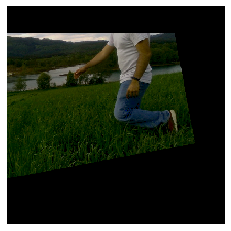

(1) Image
	+ Label: ring1, Conf: 0.99440
	+ Label: ring1, Conf: 0.98803
	+ Label: ring1, Conf: 0.95969


<Figure size 432x288 with 0 Axes>

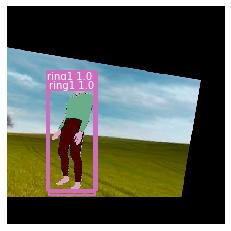

(2) Image
	+ Label: ring2, Conf: 0.78678


<Figure size 432x288 with 0 Axes>

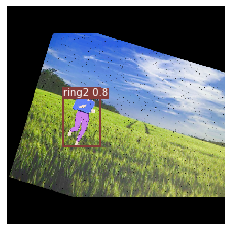

(3) Image
	+ Label: ring2, Conf: 0.74014
	+ Label: ring2, Conf: 0.61066


<Figure size 432x288 with 0 Axes>

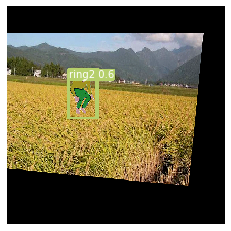

(4) Image


<Figure size 432x288 with 0 Axes>

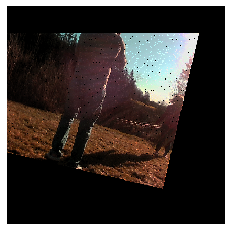

(5) Image
	+ Label: ring2, Conf: 0.99286
	+ Label: ring1, Conf: 0.99685


<Figure size 432x288 with 0 Axes>

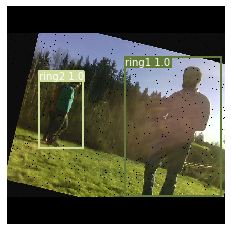

(6) Image
	+ Label: ring3, Conf: 0.92336


<Figure size 432x288 with 0 Axes>

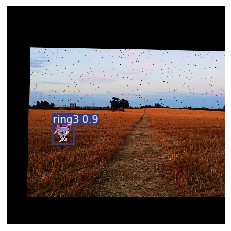

(7) Image
	+ Label: ring1, Conf: 0.70847


<Figure size 432x288 with 0 Axes>

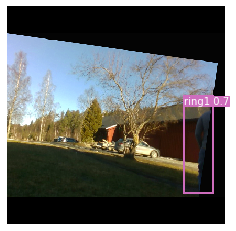

('/home/jose/datasets/simanimation_white/v4/223/Backward/augmented_image_20.jpg', '/home/jose/datasets/simanimation_white/v4/25/Backward/augmented_image_26.jpg', '/home/jose/datasets/real_iros2021/image_2326.jpg', '/home/jose/datasets/simanimation_white/v4/831/Backward/augmented_image_28.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_3602.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_48369.jpg', '/home/jose/datasets/real_iros2021/image_2524.jpg', '/home/jose/datasets/real_iros2021/image_2181.jpg') tensor([[0.0000, 1.0000, 0.4393, 0.3398, 0.1888, 0.3436],
        [1.0000, 3.0000, 0.4968, 0.6579, 0.0585, 0.1072],
        [2.0000, 2.0000, 0.6674, 0.5397, 0.1811, 0.2559],
        [2.0000, 3.0000, 0.3500, 0.4770, 0.1439, 0.1740],
        [3.0000, 2.0000, 0.4663, 0.4044, 0.1135, 0.1697],
        [4.0000, 2.0000, 0.4883, 0.4691, 0.1597, 0.3020],
        [4.0000, 0.0000, 0.1986, 0.4245, 0.3972, 0.5991],
        [5.0000, 1.0000, 0.7684, 0.5386, 0.4102, 0.672

<Figure size 432x288 with 0 Axes>

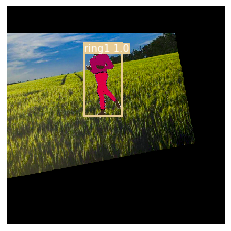

(1) Image
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 1.00000


<Figure size 432x288 with 0 Axes>

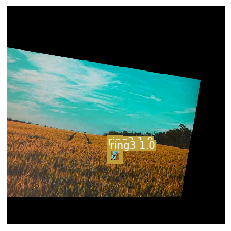

(2) Image
	+ Label: ring3, Conf: 0.99991
	+ Label: ring2, Conf: 0.70084


<Figure size 432x288 with 0 Axes>

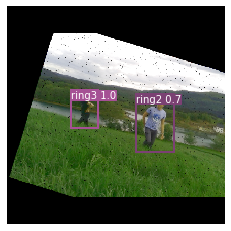

(3) Image
	+ Label: ring2, Conf: 0.96548
	+ Label: ring2, Conf: 0.96626


<Figure size 432x288 with 0 Axes>

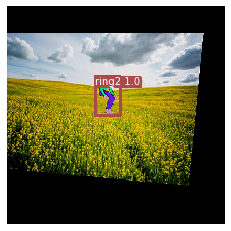

(4) Image
	+ Label: ring0, Conf: 0.99548
	+ Label: ring3, Conf: 0.78050


<Figure size 432x288 with 0 Axes>

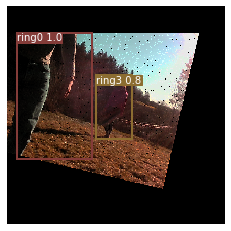

(5) Image
	+ Label: ring1, Conf: 0.99804


<Figure size 432x288 with 0 Axes>

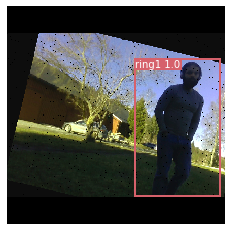

(6) Image
	+ Label: ring2, Conf: 0.99591


<Figure size 432x288 with 0 Axes>

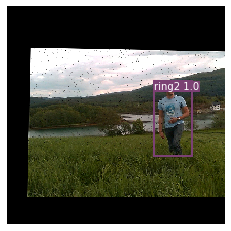

(7) Image
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 0.99996
	+ Label: ring3, Conf: 0.99999


<Figure size 432x288 with 0 Axes>

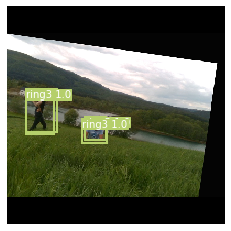

('/home/jose/datasets/simanimation_white/v4/171/Forward/augmented_image_2.jpg', '/home/jose/datasets/real_iros2021/image_3493.jpg', '/home/jose/datasets/real_iros2021/image_1238.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1006.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_527.jpg', '/home/jose/datasets/simanimation_white/v4/713/Backward/augmented_image_14.jpg', '/home/jose/datasets/simanimation_white/v4/768/Backward/augmented_image_25.jpg', '/home/jose/datasets/real_iros2021/image_889.jpg') tensor([[0.0000, 1.0000, 0.0850, 0.4134, 0.1699, 0.5123],
        [1.0000, 2.0000, 0.7650, 0.6748, 0.1582, 0.2363],
        [2.0000, 1.0000, 0.8180, 0.5922, 0.3405, 0.4671],
        [2.0000, 3.0000, 0.4638, 0.5428, 0.1004, 0.1025],
        [3.0000, 1.0000, 0.2585, 0.4110, 0.2582, 0.5504],
        [3.0000, 1.0000, 0.5362, 0.4442, 0.1680, 0.4307],
        [4.0000, 2.0000, 0.4268, 0.4371, 0.1781, 0.3192],
        [5.0000, 1.0000, 0.3993, 0.5122, 0.1611, 0.2892],


<Figure size 432x288 with 0 Axes>

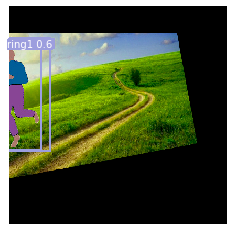

(1) Image
	+ Label: ring2, Conf: 0.97909


<Figure size 432x288 with 0 Axes>

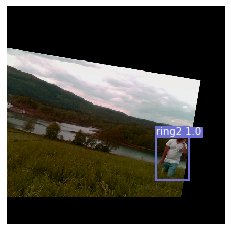

(2) Image
	+ Label: ring3, Conf: 0.99994
	+ Label: ring1, Conf: 0.99535
	+ Label: ring3, Conf: 0.99980
	+ Label: ring1, Conf: 0.99323


<Figure size 432x288 with 0 Axes>

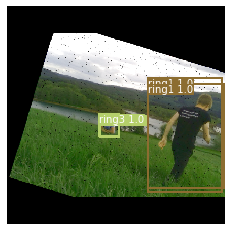

(3) Image
	+ Label: ring1, Conf: 0.99992
	+ Label: ring1, Conf: 0.94744


<Figure size 432x288 with 0 Axes>

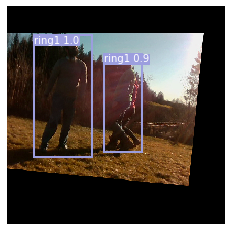

(4) Image
	+ Label: ring2, Conf: 0.96889
	+ Label: ring2, Conf: 0.78542


<Figure size 432x288 with 0 Axes>

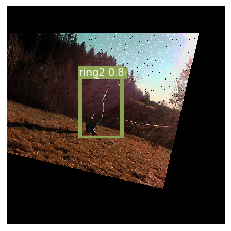

(5) Image
	+ Label: ring2, Conf: 0.56645


<Figure size 432x288 with 0 Axes>

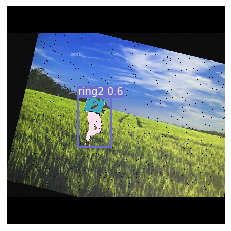

(6) Image
	+ Label: ring2, Conf: 0.96132


<Figure size 432x288 with 0 Axes>

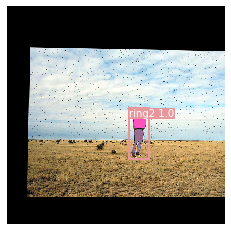

(7) Image
	+ Label: ring3, Conf: 0.99995
	+ Label: ring3, Conf: 0.99991


<Figure size 432x288 with 0 Axes>

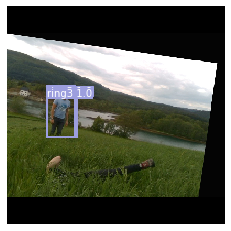

('/home/jose/datasets/real_iros2021/image_1428.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1543.jpg', '/home/jose/datasets/real_iros2021/image_2287.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_966.jpg', '/home/jose/datasets/real_iros2021/image_3078.jpg', '/home/jose/datasets/real_iros2021/image_2200.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1421.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_45843.jpg') tensor([[0.0000, 3.0000, 0.4850, 0.2868, 0.0964, 0.1588],
        [0.0000, 3.0000, 0.3119, 0.3303, 0.0814, 0.1264],
        [1.0000, 1.0000, 0.3952, 0.6183, 0.2381, 0.5133],
        [1.0000, 1.0000, 0.2549, 0.5931, 0.3105, 0.5638],
        [2.0000, 3.0000, 0.6058, 0.5274, 0.1647, 0.2197],
        [2.0000, 3.0000, 0.4739, 0.5100, 0.1295, 0.1710],
        [3.0000, 1.0000, 0.3369, 0.4280, 0.1813, 0.4243],
        [3.0000, 1.0000, 0.6982, 0.4897, 0.2111, 0.4780],
        [4.0000, 2.0000, 0.2076, 0.3041, 0.1664

<Figure size 432x288 with 0 Axes>

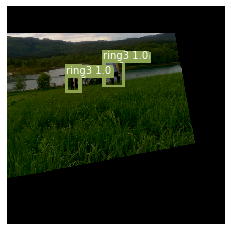

(1) Image
	+ Label: ring1, Conf: 0.99764
	+ Label: ring1, Conf: 0.99674


<Figure size 432x288 with 0 Axes>

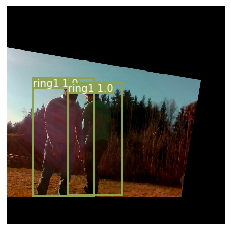

(2) Image
	+ Label: ring3, Conf: 0.99984
	+ Label: ring3, Conf: 1.00000


<Figure size 432x288 with 0 Axes>

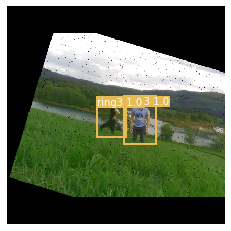

(3) Image
	+ Label: ring1, Conf: 0.84923
	+ Label: ring2, Conf: 0.81535
	+ Label: ring1, Conf: 0.66089


<Figure size 432x288 with 0 Axes>

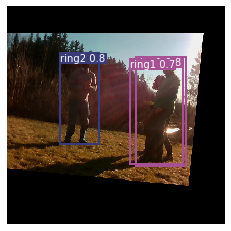

(4) Image
	+ Label: ring2, Conf: 0.94671
	+ Label: ring2, Conf: 0.81446


<Figure size 432x288 with 0 Axes>

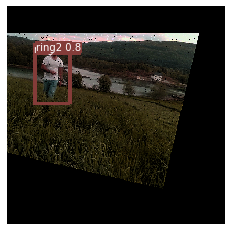

(5) Image
	+ Label: ring3, Conf: 0.99997
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 0.99999
	+ Label: ring3, Conf: 0.99998


<Figure size 432x288 with 0 Axes>

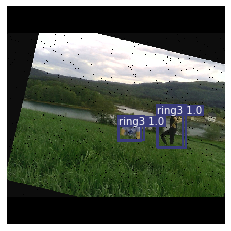

(6) Image
	+ Label: ring2, Conf: 0.98223
	+ Label: ring1, Conf: 0.99776


<Figure size 432x288 with 0 Axes>

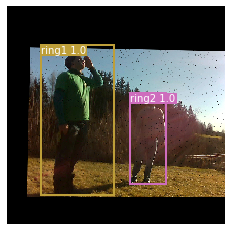

(7) Image
	+ Label: ring0, Conf: 0.78077


<Figure size 432x288 with 0 Axes>

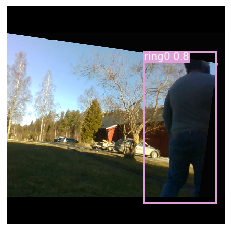

('/home/jose/datasets/house_dataset/registration/bag3/image_112.jpg', '/home/jose/datasets/real_iros2021/image_3002.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_46831.jpg', '/home/jose/datasets/simanimation_white/v4/535/Backward/augmented_image_35.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1845.jpg', '/home/jose/datasets/house_dataset/registration/bag2/image_9266.jpg', '/home/jose/datasets/real_iros2021/image_921.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1423.jpg') tensor([[0.0000, 2.0000, 0.1549, 0.4343, 0.1910, 0.3633],
        [0.0000, 2.0000, 0.0762, 0.4614, 0.1524, 0.3542],
        [1.0000, 2.0000, 0.4032, 0.6025, 0.1505, 0.3143],
        [2.0000, 1.0000, 0.4204, 0.5672, 0.2775, 0.4560],
        [3.0000, 2.0000, 0.4387, 0.4143, 0.0892, 0.1257],
        [4.0000, 1.0000, 0.5268, 0.4556, 0.3435, 0.4730],
        [4.0000, 3.0000, 0.2523, 0.4012, 0.1309, 0.2895],
        [4.0000, 0.0000, 0.0552, 0.3850, 0.1104, 0.5199],
 

<Figure size 432x288 with 0 Axes>

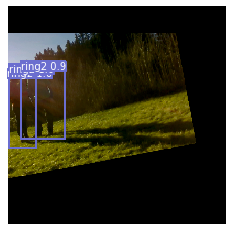

(1) Image
	+ Label: ring2, Conf: 0.99207


<Figure size 432x288 with 0 Axes>

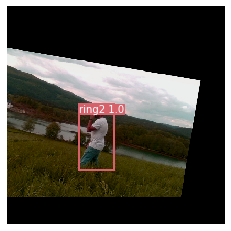

(2) Image
	+ Label: ring1, Conf: 0.83836


<Figure size 432x288 with 0 Axes>

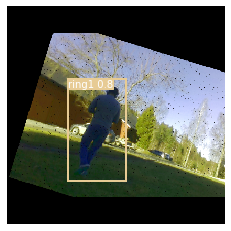

(3) Image
	+ Label: ring3, Conf: 0.85423
	+ Label: ring2, Conf: 0.58902


<Figure size 432x288 with 0 Axes>

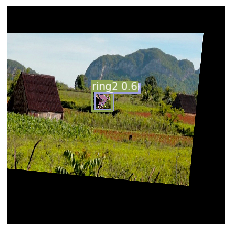

(4) Image
	+ Label: ring3, Conf: 0.99884
	+ Label: ring3, Conf: 0.99957
	+ Label: ring2, Conf: 0.92216
	+ Label: ring1, Conf: 0.90568
	+ Label: ring2, Conf: 0.76357


<Figure size 432x288 with 0 Axes>

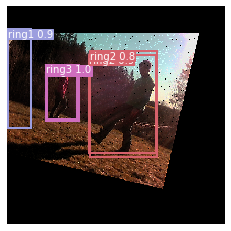

(5) Image
	+ Label: ring2, Conf: 0.97623
	+ Label: ring2, Conf: 0.97068


<Figure size 432x288 with 0 Axes>

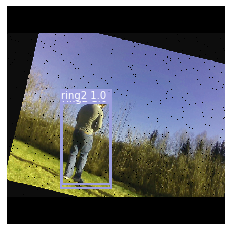

(6) Image
	+ Label: ring3, Conf: 0.99994
	+ Label: ring3, Conf: 0.99995


<Figure size 432x288 with 0 Axes>

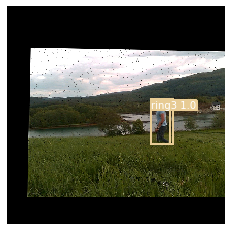

(7) Image
	+ Label: ring1, Conf: 0.99938
	+ Label: ring2, Conf: 0.95396
	+ Label: ring1, Conf: 0.99945


<Figure size 432x288 with 0 Axes>

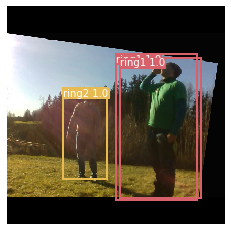

('/home/jose/datasets/house_dataset/registration/bag3/image_3225.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_45897.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_49038.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_48763.jpg', '/home/jose/datasets/real_iros2021/image_1356.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_2567.jpg', '/home/jose/datasets/real_iros2021/image_1706.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_48743.jpg') tensor([[0.0000, 1.0000, 0.4347, 0.4232, 0.3944, 0.5964],
        [0.0000, 1.0000, 0.2623, 0.4047, 0.2456, 0.4891],
        [0.0000, 1.0000, 0.1607, 0.3633, 0.1933, 0.4393],
        [1.0000, 1.0000, 0.6066, 0.6621, 0.3448, 0.4257],
        [2.0000, 0.0000, 0.8927, 0.5963, 0.2146, 0.5575],
        [3.0000, 1.0000, 0.0298, 0.4098, 0.0596, 0.4149],
        [4.0000, 3.0000, 0.1815, 0.2851, 0.1335, 0.2081],
        [4.0000, 3.0000, 0.5662, 0.3830, 0.1218, 0.1766],
       

<Figure size 432x288 with 0 Axes>

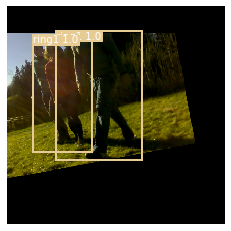

(1) Image
	+ Label: ring1, Conf: 0.98953


<Figure size 432x288 with 0 Axes>

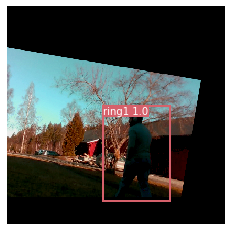

(2) Image


<Figure size 432x288 with 0 Axes>

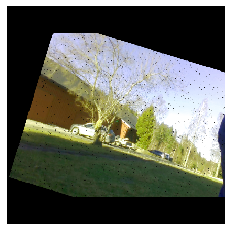

(3) Image
	+ Label: ring2, Conf: 0.94951
	+ Label: ring2, Conf: 0.89571


<Figure size 432x288 with 0 Axes>

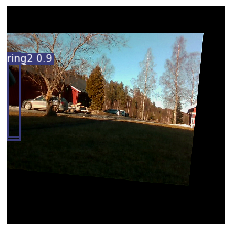

(4) Image
	+ Label: ring3, Conf: 0.99997
	+ Label: ring3, Conf: 0.99989


<Figure size 432x288 with 0 Axes>

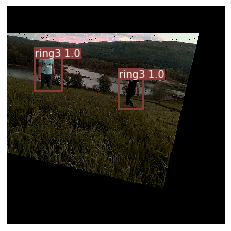

(5) Image
	+ Label: ring1, Conf: 0.97639


<Figure size 432x288 with 0 Axes>

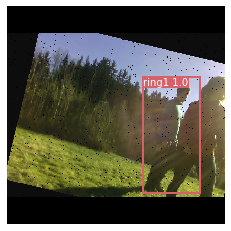

(6) Image
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 1.00000


<Figure size 432x288 with 0 Axes>

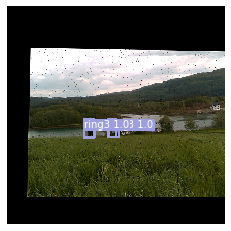

(7) Image
	+ Label: ring1, Conf: 0.97926


<Figure size 432x288 with 0 Axes>

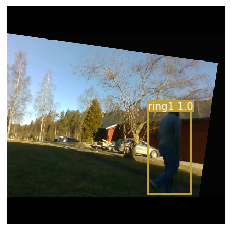

('/home/jose/datasets/house_dataset/registration/bag3/image_2862.jpg', '/home/jose/datasets/simanimation_white/v4/281/Backward/augmented_image_20.jpg', '/home/jose/datasets/real_iros2021/image_3542.jpg', '/home/jose/datasets/simanimation_white/v4/780/Backward/augmented_image_16.jpg', '/home/jose/datasets/real_iros2021/image_3059.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_3370.jpg', '/home/jose/datasets/real_iros2021/image_218.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1811.jpg') tensor([[0.0000, 0.0000, 0.3193, 0.4380, 0.4943, 0.6260],
        [0.0000, 1.0000, 0.7428, 0.2997, 0.1798, 0.3494],
        [1.0000, 3.0000, 0.3643, 0.6355, 0.0709, 0.1182],
        [2.0000, 2.0000, 0.1948, 0.4182, 0.2019, 0.2839],
        [3.0000, 3.0000, 0.3547, 0.4062, 0.0663, 0.1281],
        [4.0000, 2.0000, 0.2132, 0.3006, 0.1558, 0.2665],
        [5.0000, 0.0000, 0.4828, 0.5000, 0.8512, 0.7500],
        [5.0000, 0.0000, 0.7834, 0.6591, 0.2190, 0.4291],
        

<Figure size 432x288 with 0 Axes>

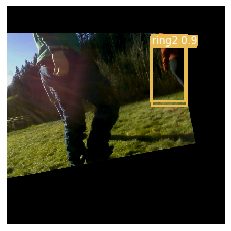

(1) Image
	+ Label: ring3, Conf: 0.99957
	+ Label: ring3, Conf: 0.99892
	+ Label: ring3, Conf: 0.99983


<Figure size 432x288 with 0 Axes>

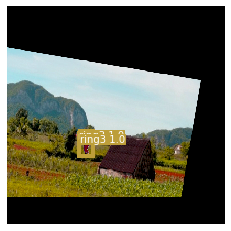

(2) Image
	+ Label: ring2, Conf: 0.98476


<Figure size 432x288 with 0 Axes>

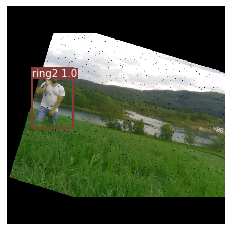

(3) Image
	+ Label: ring3, Conf: 0.99993
	+ Label: ring3, Conf: 0.99886
	+ Label: ring3, Conf: 0.99970


<Figure size 432x288 with 0 Axes>

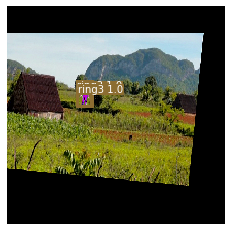

(4) Image
	+ Label: ring2, Conf: 0.84329


<Figure size 432x288 with 0 Axes>

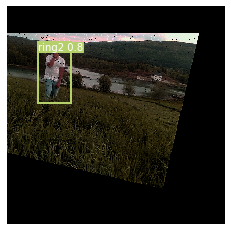

(5) Image
	+ Label: ring0, Conf: 0.99029
	+ Label: ring1, Conf: 0.44076


<Figure size 432x288 with 0 Axes>

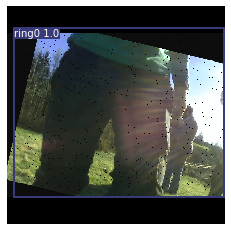

(6) Image
	+ Label: ring0, Conf: 0.98794


<Figure size 432x288 with 0 Axes>

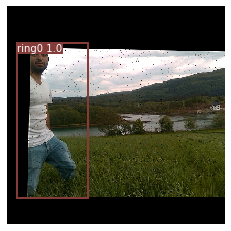

(7) Image
	+ Label: ring2, Conf: 0.96534
	+ Label: ring1, Conf: 0.99581


<Figure size 432x288 with 0 Axes>

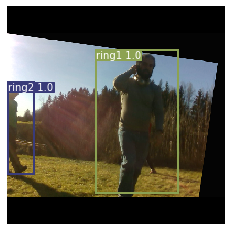

('/home/jose/datasets/house_dataset/registration/bag3/image_2970.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_832.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1994.jpg', '/home/jose/datasets/real_iros2021/image_310.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_46181.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1080.jpg', '/home/jose/datasets/real_iros2021/image_846.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_677.jpg') tensor([[0.0000, 1.0000, 0.6125, 0.3545, 0.3477, 0.4590],
        [0.0000, 1.0000, 0.1525, 0.4508, 0.3050, 0.6515],
        [0.0000, 2.0000, 0.2154, 0.4262, 0.1597, 0.3307],
        [1.0000, 1.0000, 0.7169, 0.6381, 0.2916, 0.4738],
        [2.0000, 1.0000, 0.6549, 0.5760, 0.3840, 0.5981],
        [2.0000, 2.0000, 0.9437, 0.7429, 0.1126, 0.2641],
        [3.0000, 0.0000, 0.7834, 0.4529, 0.2407, 0.6558],
        [4.0000, 2.0000, 0.7630, 0.4884, 0.1492, 0.4045],
        [5.000

<Figure size 432x288 with 0 Axes>

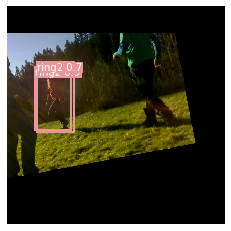

(1) Image
	+ Label: ring1, Conf: 0.99905


<Figure size 432x288 with 0 Axes>

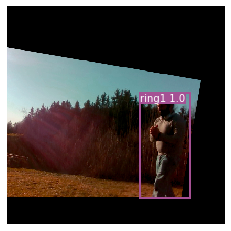

(2) Image
	+ Label: ring1, Conf: 0.99961
	+ Label: ring1, Conf: 0.99903


<Figure size 432x288 with 0 Axes>

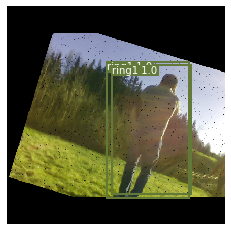

(3) Image


<Figure size 432x288 with 0 Axes>

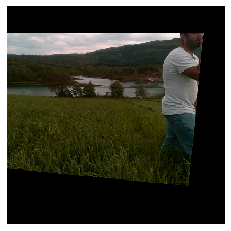

(4) Image


<Figure size 432x288 with 0 Axes>

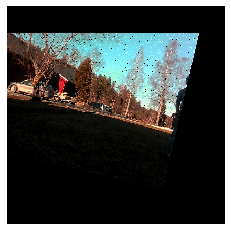

(5) Image
	+ Label: ring2, Conf: 0.98634
	+ Label: ring2, Conf: 0.98591
	+ Label: ring1, Conf: 0.99974
	+ Label: ring1, Conf: 0.99961


<Figure size 432x288 with 0 Axes>

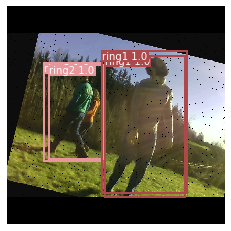

(6) Image
	+ Label: ring1, Conf: 0.98045
	+ Label: ring3, Conf: 0.85718


<Figure size 432x288 with 0 Axes>

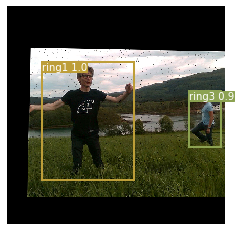

(7) Image
	+ Label: ring2, Conf: 0.97002
	+ Label: ring2, Conf: 0.98952
	+ Label: ring0, Conf: 0.98604


<Figure size 432x288 with 0 Axes>

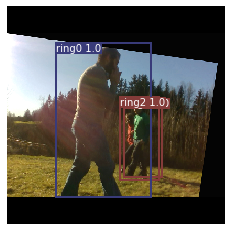

('/home/jose/datasets/house_dataset/registration/bag3/image_2755.jpg', '/home/jose/datasets/simanimation_white/v4/91/Forward/augmented_image_15.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_3218.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1811.jpg', '/home/jose/datasets/simanimation_white/v4/746/Forward/augmented_image_18.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1339.jpg', '/home/jose/datasets/house_dataset/registration/bag1/image_46353.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1459.jpg') tensor([[0.0000, 2.0000, 0.1528, 0.4315, 0.1871, 0.3744],
        [1.0000, 1.0000, 0.5226, 0.6274, 0.1389, 0.2106],
        [2.0000, 1.0000, 0.4352, 0.5243, 0.4225, 0.6954],
        [2.0000, 1.0000, 0.6246, 0.6263, 0.3210, 0.4964],
        [2.0000, 1.0000, 0.7091, 0.6276, 0.2152, 0.4072],
        [3.0000, 1.0000, 0.1985, 0.4441, 0.3250, 0.6383],
        [3.0000, 1.0000, 0.7541, 0.4966, 0.2079, 0.4130],
        [4.00

<Figure size 432x288 with 0 Axes>

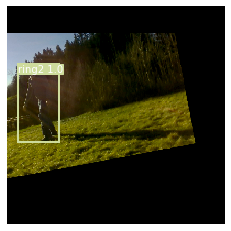

(1) Image
	+ Label: ring2, Conf: 0.92256


<Figure size 432x288 with 0 Axes>

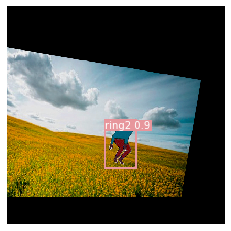

(2) Image
	+ Label: ring1, Conf: 0.99870
	+ Label: ring1, Conf: 0.97162
	+ Label: ring1, Conf: 0.97949
	+ Label: ring1, Conf: 0.74911


<Figure size 432x288 with 0 Axes>

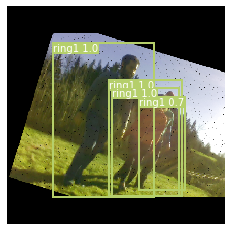

(3) Image
	+ Label: ring2, Conf: 0.99262
	+ Label: ring2, Conf: 0.98561
	+ Label: ring1, Conf: 0.99338


<Figure size 432x288 with 0 Axes>

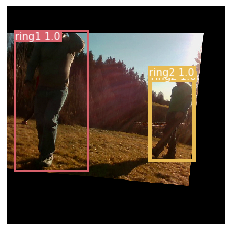

(4) Image
	+ Label: ring2, Conf: 0.82383
	+ Label: ring2, Conf: 0.80112
	+ Label: ring3, Conf: 0.60599


<Figure size 432x288 with 0 Axes>

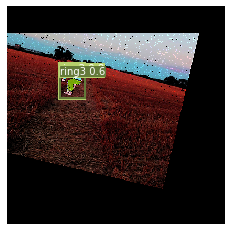

(5) Image
	+ Label: ring2, Conf: 0.98928
	+ Label: ring1, Conf: 0.99703
	+ Label: ring1, Conf: 0.80611


<Figure size 432x288 with 0 Axes>

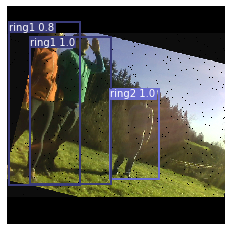

(6) Image
	+ Label: ring2, Conf: 0.56992


<Figure size 432x288 with 0 Axes>

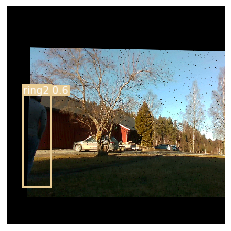

(7) Image
	+ Label: ring1, Conf: 0.99956
	+ Label: ring1, Conf: 0.89064


<Figure size 432x288 with 0 Axes>

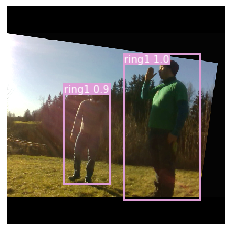

('/home/jose/datasets/real_iros2021/image_1803.jpg', '/home/jose/datasets/simanimation_white/v4/115/Backward/augmented_image_32.jpg', '/home/jose/datasets/real_iros2021/image_1074.jpg', '/home/jose/datasets/real_iros2021/image_1867.jpg', '/home/jose/datasets/house_dataset/registration/bag3/image_1223.jpg', '/home/jose/datasets/simanimation_white/v4/595/Backward/augmented_image_53.jpg', '/home/jose/datasets/simanimation_white/v4/367/Forward/augmented_image_11.jpg', '/home/jose/datasets/simanimation_white/v4/678/Backward/augmented_image_37.jpg') tensor([[0.0000, 3.0000, 0.2307, 0.3550, 0.0595, 0.0882],
        [0.0000, 3.0000, 0.7632, 0.2697, 0.0621, 0.0783],
        [1.0000, 1.0000, 0.5013, 0.6222, 0.2211, 0.4400],
        [2.0000, 1.0000, 0.6185, 0.6408, 0.3326, 0.4634],
        [2.0000, 3.0000, 0.4625, 0.5473, 0.1020, 0.0989],
        [3.0000, 3.0000, 0.4988, 0.3934, 0.0698, 0.1161],
        [3.0000, 3.0000, 0.2460, 0.3611, 0.0788, 0.1139],
        [4.0000, 1.0000, 0.3077, 0.4045, 0.2

<Figure size 432x288 with 0 Axes>

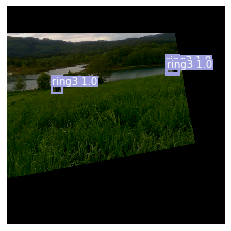

(1) Image


<Figure size 432x288 with 0 Axes>

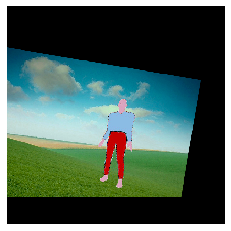

(2) Image
	+ Label: ring1, Conf: 0.99201
	+ Label: ring3, Conf: 0.99857


<Figure size 432x288 with 0 Axes>

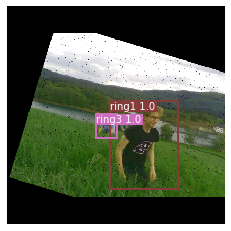

(3) Image
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 1.00000
	+ Label: ring3, Conf: 1.00000


<Figure size 432x288 with 0 Axes>

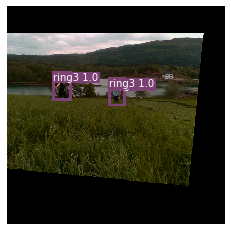

(4) Image
	+ Label: ring1, Conf: 0.81996


<Figure size 432x288 with 0 Axes>

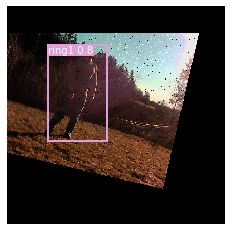

(5) Image


<Figure size 432x288 with 0 Axes>

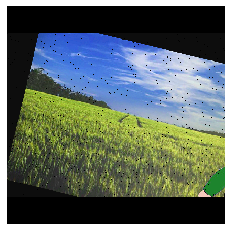

(6) Image
	+ Label: ring1, Conf: 0.71614


<Figure size 432x288 with 0 Axes>

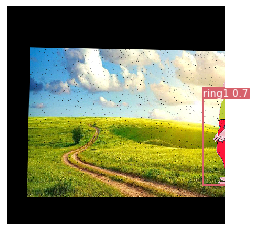

(7) Image
	+ Label: ring2, Conf: 0.67803
	+ Label: ring2, Conf: 0.51850


<Figure size 432x288 with 0 Axes>

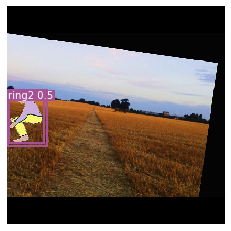

In [17]:
for j in range(10):
    plot_results(j)

In [18]:
c

3